# Convolutional Networks
So far we have worked with deep fully-connected networks, using them to explore different optimization strategies and network architectures. Fully-connected networks are a good testbed for experimentation because they are very computationally efficient, but in practice all state-of-the-art results use convolutional networks instead.

First you will implement several layer types that are used in convolutional networks. You will then use these layers to train a convolutional network on the CIFAR-10 dataset.

In [1]:
# As usual, a bit of setup

from sklearn.externals import joblib
import os
import numpy as np
import matplotlib.pyplot as plt
from cs231n.classifiers.cnn import *
from cs231n.data_utils import get_CIFAR10_data
from cs231n.gradient_check import eval_numerical_gradient_array, eval_numerical_gradient
from cs231n.layers import *
from cs231n.fast_layers import *
from cs231n.solver import Solver

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


run the following from the cs231n directory and try again:
python setup.py build_ext --inplace
You may also need to restart your iPython kernel


In [2]:
# Load the (preprocessed) CIFAR10 data.
DIR_CS231n = 'd:/lecture/CS231/assignment2/'
data = get_CIFAR10_data(DIR_CS231n)
for k, v in data.items():
  print ('%s: ' % k, v.shape)

X_train:  (49000, 3, 32, 32)
y_train:  (49000,)
X_val:  (1000, 3, 32, 32)
y_val:  (1000,)
X_test:  (1000, 3, 32, 32)
y_test:  (1000,)


# Convolution: Naive forward pass
The core of a convolutional network is the convolution operation. In the file `cs231n/layers.py`, implement the forward pass for the convolution layer in the function `conv_forward_naive`. 

You don't have to worry too much about efficiency at this point; just write the code in whatever way you find most clear.

You can test your implementation by running the following:

In [3]:
x_shape = (2, 3, 4, 4)
w_shape = (3, 3, 4, 4)
x = np.linspace(-0.1, 0.5, num=np.prod(x_shape)).reshape(x_shape)
w = np.linspace(-0.2, 0.3, num=np.prod(w_shape)).reshape(w_shape)
b = np.linspace(-0.1, 0.2, num=3)

conv_param = {'stride': 2, 'pad': 1}
out, _ = conv_forward_naive(x, w, b, conv_param)
correct_out = np.array([[[[[-0.08759809, -0.10987781],
                           [-0.18387192, -0.2109216 ]],
                          [[ 0.21027089,  0.21661097],
                           [ 0.22847626,  0.23004637]],
                          [[ 0.50813986,  0.54309974],
                           [ 0.64082444,  0.67101435]]],
                         [[[-0.98053589, -1.03143541],
                           [-1.19128892, -1.24695841]],
                          [[ 0.69108355,  0.66880383],
                           [ 0.59480972,  0.56776003]],
                          [[ 2.36270298,  2.36904306],
                           [ 2.38090835,  2.38247847]]]]])

# Compare your output to ours; difference should be around 1e-8
print ('Testing conv_forward_naive')
print ('difference: ', rel_error(out, correct_out))

Testing conv_forward_naive
difference:  2.2121476417505994e-08


# Aside: Image processing via convolutions

As fun way to both check your implementation and gain a better understanding of the type of operation that convolutional layers can perform, we will set up an input containing two images and manually set up filters that perform common image processing operations (grayscale conversion and edge detection). The convolution forward pass will apply these operations to each of the input images. We can then visualize the results as a sanity check.

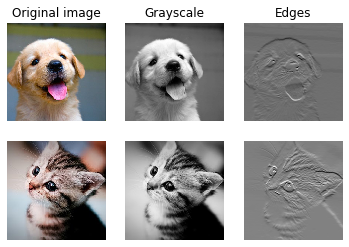

In [4]:
from imageio import imread
from skimage.transform import resize as imresize

kitten, puppy = imread('kitten.jpg'), imread('puppy.jpg')
# kitten is wide, and puppy is already square
d = kitten.shape[1] - kitten.shape[0]
kitten_cropped = kitten[:, int(d/2):-int(d/2), :]

img_size = 200   # Make this smaller if it runs too slow
x = np.zeros((2, 3, img_size, img_size))
x[0, :, :, :] = imresize(puppy, (img_size, img_size)).transpose((2, 0, 1))
x[1, :, :, :] = imresize(kitten_cropped, (img_size, img_size)).transpose((2, 0, 1))

# Set up a convolutional weights holding 2 filters, each 3x3
w = np.zeros((2, 3, 3, 3))

# The first filter converts the image to grayscale.
# Set up the red, green, and blue channels of the filter.
w[0, 0, :, :] = [[0, 0, 0], [0, 0.3, 0], [0, 0, 0]]
w[0, 1, :, :] = [[0, 0, 0], [0, 0.6, 0], [0, 0, 0]]
w[0, 2, :, :] = [[0, 0, 0], [0, 0.1, 0], [0, 0, 0]]

# Second filter detects horizontal edges in the blue channel.
w[1, 2, :, :] = [[1, 2, 1], [0, 0, 0], [-1, -2, -1]]

# Vector of biases. We don't need any bias for the grayscale
# filter, but for the edge detection filter we want to add 128
# to each output so that nothing is negative.
b = np.array([0, 128])

# Compute the result of convolving each input in x with each filter in w,
# offsetting by b, and storing the results in out.
out, _ = conv_forward_naive(x, w, b, {'stride': 1, 'pad': 1})

def imshow_noax(img, normalize=True):
    """ Tiny helper to show images as uint8 and remove axis labels """
    if normalize:
        img_max, img_min = np.max(img), np.min(img)
        img = 255.0 * (img - img_min) / (img_max - img_min)
    plt.imshow(img.astype('uint8'))
    plt.gca().axis('off')

# Show the original images and the results of the conv operation
plt.subplot(2, 3, 1)
imshow_noax(puppy, normalize=False)
plt.title('Original image')
plt.subplot(2, 3, 2)
imshow_noax(out[0, 0])
plt.title('Grayscale')
plt.subplot(2, 3, 3)
imshow_noax(out[0, 1])
plt.title('Edges')
plt.subplot(2, 3, 4)
imshow_noax(kitten_cropped, normalize=False)
plt.subplot(2, 3, 5)
imshow_noax(out[1, 0])
plt.subplot(2, 3, 6)
imshow_noax(out[1, 1])
plt.show()

# Convolution: Naive backward pass
Implement the backward pass for the convolution operation in the function `conv_backward_naive` in the file `cs231n/layers.py`. Again, you don't need to worry too much about computational efficiency.

When you are done, run the following to check your backward pass with a numeric gradient check.

In [5]:
from time import time
x = np.random.randn(4, 3, 5, 5)
w = np.random.randn(2, 3, 3, 3)
b = np.random.randn(2,)
dout = np.random.randn(4, 2, 5, 5)
conv_param = {'stride': 1, 'pad': 1}

dx_num = eval_numerical_gradient_array(lambda x: conv_forward_naive(x, w, b, conv_param)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: conv_forward_naive(x, w, b, conv_param)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: conv_forward_naive(x, w, b, conv_param)[0], b, dout)

out, cache = conv_forward_naive(x, w, b, conv_param)
dx, dw, db = conv_backward_naive(dout, cache)

# Your errors should be around 1e-9'
print ('Testing conv_backward_naive function')
print ('dx error: ', rel_error(dx, dx_num))
print ('dw error: ', rel_error(dw, dw_num))
print ('db error: ', rel_error(db, db_num))

Testing conv_backward_naive function
dx error:  3.794695649567357e-08
dw error:  7.201753150447431e-10
db error:  1.2622095181860709e-12


# Max pooling: Naive forward
Implement the forward pass for the max-pooling operation in the function `max_pool_forward_naive` in the file `cs231n/layers.py`. Again, don't worry too much about computational efficiency.

Check your implementation by running the following:

In [6]:
x_shape = (2, 3, 4, 4)
x = np.linspace(-0.3, 0.4, num=np.prod(x_shape)).reshape(x_shape)
pool_param = {'pool_width': 2, 'pool_height': 2, 'stride': 2}

out, _ = max_pool_forward_naive(x, pool_param)

correct_out = np.array([[[[-0.26315789, -0.24842105],
                          [-0.20421053, -0.18947368]],
                         [[-0.14526316, -0.13052632],
                          [-0.08631579, -0.07157895]],
                         [[-0.02736842, -0.01263158],
                          [ 0.03157895,  0.04631579]]],
                        [[[ 0.09052632,  0.10526316],
                          [ 0.14947368,  0.16421053]],
                         [[ 0.20842105,  0.22315789],
                          [ 0.26736842,  0.28210526]],
                         [[ 0.32631579,  0.34105263],
                          [ 0.38526316,  0.4       ]]]])

# Compare your output with ours. Difference should be around 1e-8.
print( 'Testing max_pool_forward_naive function:')
print ('difference: ', rel_error(out, correct_out))

Testing max_pool_forward_naive function:
difference:  4.1666665157267834e-08


# Max pooling: Naive backward
Implement the backward pass for the max-pooling operation in the function `max_pool_backward_naive` in the file `cs231n/layers.py`. You don't need to worry about computational efficiency.

Check your implementation with numeric gradient checking by running the following:

In [7]:
x = np.random.randn(3, 2, 8, 8)
dout = np.random.randn(3, 2, 4, 4)
pool_param = {'pool_height': 2, 'pool_width': 2, 'stride': 2}

dx_num = eval_numerical_gradient_array(lambda x: max_pool_forward_naive(x, pool_param)[0], x, dout)

out, cache = max_pool_forward_naive(x, pool_param)
dx = max_pool_backward_naive(dout, cache)

# Your error should be around 1e-12
print ('Testing max_pool_backward_naive function:')
print ('dx error: ', rel_error(dx, dx_num))

Testing max_pool_backward_naive function:
dx error:  3.275630920860593e-12


# Fast layers
Making convolution and pooling layers fast can be challenging. To spare you the pain, we've provided fast implementations of the forward and backward passes for convolution and pooling layers in the file `cs231n/fast_layers.py`.

The fast convolution implementation depends on a Cython extension; to compile it you need to run the following from the `cs231n` directory:

```bash
python setup.py build_ext --inplace
```

The API for the fast versions of the convolution and pooling layers is exactly the same as the naive versions that you implemented above: the forward pass receives data, weights, and parameters and produces outputs and a cache object; the backward pass recieves upstream derivatives and the cache object and produces gradients with respect to the data and weights.

**NOTE:** The fast implementation for pooling will only perform optimally if the pooling regions are non-overlapping and tile the input. If these conditions are not met then the fast pooling implementation will not be much faster than the naive implementation.

You can compare the performance of the naive and fast versions of these layers by running the following:

In [14]:
from cs231n.fast_layers import conv_forward_fast, conv_backward_fast
from time import time

x = np.random.randn(100, 3, 31, 31)
w = np.random.randn(25, 3, 3, 3)
b = np.random.randn(25,)
dout = np.random.randn(100, 25, 16, 16)
conv_param = {'stride': 2, 'pad': 1}

t0 = time()
out_naive, cache_naive = conv_forward_naive(x, w, b, conv_param)
t1 = time()
out_fast, cache_fast = conv_forward_fast(x, w, b, conv_param)
t2 = time()

print ('Testing conv_forward_fast:')
print ('Naive: %fs' % (t1 - t0))
print ('Fast: %fs' % (t2 - t1))
print ('Speedup: %fx' % ((t1 - t0) / (t2 - t1)))
#print 'Difference: ', rel_error(out_naive, out_fast)

t0 = time()
dx_naive, dw_naive, db_naive = conv_backward_naive(dout, cache_naive)
t1 = time()
dx_fast, dw_fast, db_fast = conv_backward_fast(dout, cache_fast)
t2 = time()

print ('\nTesting conv_backward_fast:')
print ('Naive: %fs' % (t1 - t0))
print ('Fast: %fs' % (t2 - t1))
print ('Speedup: %fx' % ((t1 - t0) / (t2 - t1)))
#print 'dx difference: ', rel_error(dx_naive, dx_fast)
#print 'dw difference: ', rel_error(dw_naive, dw_fast)
#print 'db difference: ', rel_error(db_naive, db_fast)

(100, 3, 31, 31) 3 3 1 2
Testing conv_forward_fast:
Naive: 3.907094s
Fast: 0.025985s
Speedup: 150.360939x

Testing conv_backward_fast:
Naive: 6.105520s
Fast: 0.058950s
Speedup: 103.570828x


In [16]:
from cs231n.fast_layers import max_pool_forward_fast, max_pool_backward_fast

x = np.random.randn(100, 3, 32, 32)
dout = np.random.randn(100, 3, 16, 16)
pool_param = {'pool_height': 2, 'pool_width': 2, 'stride': 2}

t0 = time()
out_naive, cache_naive = max_pool_forward_naive(x, pool_param)
t1 = time()
out_fast, cache_fast = max_pool_forward_fast(x, pool_param)
t2 = time()

print ('Testing pool_forward_fast:')
print ('Naive: %fs' % (t1 - t0))
print ('fast: %fs' % (t2 - t1))
print ('speedup: %fx' % ((t1 - t0) / (t2 - t1)))
print ('difference: ', rel_error(out_naive, out_fast))

t0 = time()
dx_naive = max_pool_backward_naive(dout, cache_naive)
t1 = time()
dx_fast = max_pool_backward_fast(dout, cache_fast)
t2 = time()

print ('\nTesting pool_backward_fast:')
print ('Naive: %fs' % (t1 - t0))
print ('speedup: %fx' % ((t1 - t0) / (t2 - t1)))
print ('dx difference: ', rel_error(dx_naive, dx_fast))

Testing pool_forward_fast:
Naive: 0.111940s
fast: 0.003997s
speedup: 28.003758x
difference:  0.0

Testing pool_backward_fast:
Naive: 0.393790s
speedup: 35.820278x
dx difference:  0.0


# Convolutional "sandwich" layers
Previously we introduced the concept of "sandwich" layers that combine multiple operations into commonly used patterns. In the file `cs231n/layer_utils.py` you will find sandwich layers that implement a few commonly used patterns for convolutional networks.

## Testing conv_relu_pool_forward 

In [19]:
from cs231n.layer_utils import conv_relu_pool_forward, conv_relu_pool_backward

x = np.random.randn(2, 3, 16, 16)
w = np.random.randn(3, 3, 3, 3)
b = np.random.randn(3,)
dout = np.random.randn(2, 3, 8, 8)
conv_param = {'stride': 1, 'pad': 1}
pool_param = {'pool_height': 2, 'pool_width': 2, 'stride': 2}

out, cache = conv_relu_pool_forward(x, w, b, conv_param, pool_param)
dx, dw, db = conv_relu_pool_backward(dout, cache)

dx_num = eval_numerical_gradient_array(lambda x: conv_relu_pool_forward(x, w, b, conv_param, pool_param)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: conv_relu_pool_forward(x, w, b, conv_param, pool_param)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: conv_relu_pool_forward(x, w, b, conv_param, pool_param)[0], b, dout)

print ('Testing conv_relu_pool')
print ('dx error: ', rel_error(dx_num, dx))
print ('dw error: ', rel_error(dw_num, dw))
print ('db error: ', rel_error(db_num, db))

Testing conv_relu_pool
dx error:  8.790548606879022e-09
dw error:  1.3028163832251628e-09
db error:  1.6298542751402638e-11


## Testing conv_relu_forward 

In [21]:
from cs231n.layer_utils import conv_relu_forward, conv_relu_backward

x = np.random.randn(2, 3, 8, 8)
w = np.random.randn(3, 3, 3, 3)
b = np.random.randn(3,)
dout = np.random.randn(2, 3, 8, 8)
conv_param = {'stride': 1, 'pad': 1}

out, cache = conv_relu_forward(x, w, b, conv_param)
dx, dw, db = conv_relu_backward(dout, cache)

dx_num = eval_numerical_gradient_array(lambda x: conv_relu_forward(x, w, b, conv_param)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: conv_relu_forward(x, w, b, conv_param)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: conv_relu_forward(x, w, b, conv_param)[0], b, dout)

print ('Testing conv_relu:')
print ('dx error: ', rel_error(dx_num, dx))
print ('dw error: ', rel_error(dw_num, dw))
print ('db error: ', rel_error(db_num, db))

Testing conv_relu:
dx error:  1.5934442172617108e-09
dw error:  8.294959682647782e-10
db error:  1.5292731331529485e-11


# Three-layer ConvNet
Now that you have implemented all the necessary layers, we can put them together into a simple convolutional network.

Open the file `cs231n/cnn.py` and complete the implementation of the `ThreeLayerConvNet` class. Run the following cells to help you debug:

## Sanity check loss
After you build a new network, one of the first things you should do is sanity check the loss. When we use the softmax loss, we expect the loss for random weights (and no regularization) to be about `log(C)` for `C` classes. When we add regularization this should go up.

In [23]:
model = ThreeLayerConvNet()

N = 50
X = np.random.randn(N, 3, 32, 32)
y = np.random.randint(10, size=N)

loss, grads = model.loss(X, y)
print ('Initial loss (no regularization): ', loss)

model.reg = 0.5
loss, grads = model.loss(X, y)
print ('Initial loss (with regularization): ', loss)

Initial loss (no regularization):  2.302585531822132
Initial loss (with regularization):  2.7150761977347604


## Gradient check
After the loss looks reasonable, use numeric gradient checking to make sure that your backward pass is correct. When you use numeric gradient checking you should use a small amount of artifical data and a small number of neurons at each layer.

In [25]:
num_inputs = 2
input_dim = (3, 10, 10)
reg = 0.0
num_classes = 10
X = np.random.randn(num_inputs, *input_dim)
y = np.random.randint(num_classes, size=num_inputs)

model = ThreeLayerConvNet(num_filters=3, filter_size=3,
                          input_dim=input_dim, hidden_dim=7,
                          dtype=np.float64)
loss, grads = model.loss(X, y)
for param_name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    param_grad_num = eval_numerical_gradient(f, model.params[param_name], verbose=False, h=1e-6)
    e = rel_error(param_grad_num, grads[param_name])
    print ('%s max relative error: %e' % (param_name, rel_error(param_grad_num, grads[param_name])))

W1 max relative error: 1.995949e-04
W2 max relative error: 1.679798e-02
W3 max relative error: 9.616121e-04
b1 max relative error: 4.490631e-05
b2 max relative error: 6.135531e-06
b3 max relative error: 1.822731e-09


## Overfit small data
A nice trick is to train your model with just a few training samples. You should be able to overfit small datasets, which will result in very high training accuracy and comparatively low validation accuracy.

In [26]:
num_train = 100
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

model = ThreeLayerConvNet(weight_scale=1e-2)

solver = Solver(model, small_data,
                num_epochs=20, batch_size=50,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-3,
                },
                verbose=True, print_every=1)
solver.train()

(Iteration 1 / 40) loss: 2.385123
(Epoch 0 / 20) train acc: 0.180000; val_acc: 0.121000
(Iteration 2 / 40) loss: 2.530678
(Epoch 1 / 20) train acc: 0.200000; val_acc: 0.119000
(Iteration 3 / 40) loss: 2.792873
(Iteration 4 / 40) loss: 2.012111
(Epoch 2 / 20) train acc: 0.450000; val_acc: 0.112000
(Iteration 5 / 40) loss: 1.898725
(Iteration 6 / 40) loss: 1.817038
(Epoch 3 / 20) train acc: 0.440000; val_acc: 0.175000
(Iteration 7 / 40) loss: 1.659761
(Iteration 8 / 40) loss: 1.567412
(Epoch 4 / 20) train acc: 0.660000; val_acc: 0.187000
(Iteration 9 / 40) loss: 1.216696
(Iteration 10 / 40) loss: 1.250335
(Epoch 5 / 20) train acc: 0.690000; val_acc: 0.157000
(Iteration 11 / 40) loss: 1.041959
(Iteration 12 / 40) loss: 1.034847
(Epoch 6 / 20) train acc: 0.780000; val_acc: 0.187000
(Iteration 13 / 40) loss: 0.684079
(Iteration 14 / 40) loss: 0.691587
(Epoch 7 / 20) train acc: 0.850000; val_acc: 0.199000
(Iteration 15 / 40) loss: 0.681423
(Iteration 16 / 40) loss: 0.593043
(Epoch 8 / 20) tr

Plotting the loss, training accuracy, and validation accuracy should show clear overfitting:

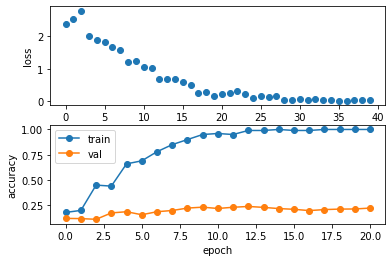

In [27]:
plt.subplot(2, 1, 1)
plt.plot(solver.loss_history, 'o')
plt.xlabel('iteration')
plt.ylabel('loss')

plt.subplot(2, 1, 2)
plt.plot(solver.train_acc_history, '-o')
plt.plot(solver.val_acc_history, '-o')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

## Train the net
By training the three-layer convolutional network for one epoch, you should achieve greater than 40% accuracy on the training set:

In [28]:
model = ThreeLayerConvNet(weight_scale=0.001, hidden_dim=500, reg=0.001)

solver = Solver(model, data,
                num_epochs=1, batch_size=50,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-3,
                },
                verbose=True, print_every=20)
solver.train()

(Iteration 1 / 980) loss: 2.306703
(Epoch 0 / 1) train acc: 0.089000; val_acc: 0.105000
(Iteration 21 / 980) loss: 2.046957
(Iteration 41 / 980) loss: 2.153856
(Iteration 61 / 980) loss: 1.899687
(Iteration 81 / 980) loss: 1.667356
(Iteration 101 / 980) loss: 2.026211
(Iteration 121 / 980) loss: 2.043518
(Iteration 141 / 980) loss: 1.972523
(Iteration 161 / 980) loss: 1.776416
(Iteration 181 / 980) loss: 1.667397
(Iteration 201 / 980) loss: 1.771184
(Iteration 221 / 980) loss: 1.762893
(Iteration 241 / 980) loss: 1.554556
(Iteration 261 / 980) loss: 1.580958
(Iteration 281 / 980) loss: 1.670856
(Iteration 301 / 980) loss: 1.850143
(Iteration 321 / 980) loss: 1.693223
(Iteration 341 / 980) loss: 1.986063
(Iteration 361 / 980) loss: 1.572694
(Iteration 381 / 980) loss: 2.087185
(Iteration 401 / 980) loss: 1.521436
(Iteration 421 / 980) loss: 1.853996
(Iteration 441 / 980) loss: 1.846938
(Iteration 461 / 980) loss: 1.875123
(Iteration 481 / 980) loss: 1.855493
(Iteration 501 / 980) loss: 

## Visualize Filters
You can visualize the first-layer convolutional filters from the trained network by running the following:

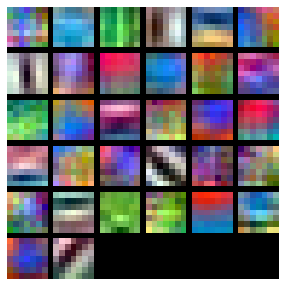

In [31]:
from cs231n.vis_utils import visualize_grid

grid = visualize_grid(model.params['W1'].transpose(0, 2, 3, 1))
plt.imshow(grid.astype('uint8'))
plt.axis('off')
plt.gcf().set_size_inches(5, 5)
plt.show()

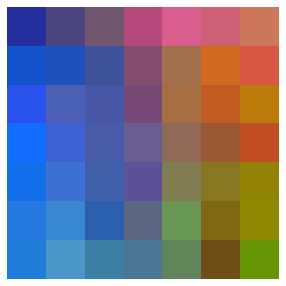

In [32]:
img = model.params['W1'].transpose(0, 2, 3, 1)[5]
low, high = np.min(img), np.max(img)
img = 255 * (img - low) / (high - low)
plt.imshow(img.astype('uint8'))
plt.axis('off')
plt.gcf().set_size_inches(5, 5)

# Spatial Batch Normalization
We already saw that batch normalization is a very useful technique for training deep fully-connected networks. Batch normalization can also be used for convolutional networks, but we need to tweak it a bit; the modification will be called "spatial batch normalization."

Normally batch-normalization accepts inputs of shape `(N, D)` and produces outputs of shape `(N, D)`, where we normalize across the minibatch dimension `N`. For data coming from convolutional layers, batch normalization needs to accept inputs of shape `(N, C, H, W)` and produce outputs of shape `(N, C, H, W)` where the `N` dimension gives the minibatch size and the `(H, W)` dimensions give the spatial size of the feature map.

If the feature map was produced using convolutions, then we expect the statistics of each feature channel to be relatively consistent both between different images and different locations within the same image. Therefore spatial batch normalization computes a mean and variance for each of the `C` feature channels by computing statistics over both the minibatch dimension `N` and the spatial dimensions `H` and `W`.

## Spatial batch normalization: forward

In the file `cs231n/layers.py`, implement the forward pass for spatial batch normalization in the function `spatial_batchnorm_forward`. Check your implementation by running the following:

In [33]:
# Check the training-time forward pass by checking means and variances
# of features both before and after spatial batch normalization

N, C, H, W = 2, 3, 4, 5
x = 4 * np.random.randn(N, C, H, W) + 10

print ('Before spatial batch normalization:')
print ('  Shape: ', x.shape)
print ('  Means: ', x.mean(axis=(0, 2, 3)))
print ('  Stds: ', x.std(axis=(0, 2, 3)))

# Means should be close to zero and stds close to one
gamma, beta = np.ones(C), np.zeros(C)
bn_param = {'mode': 'train'}
out, _ = spatial_batchnorm_forward(x, gamma, beta, bn_param)
print ('After spatial batch normalization:')
print ('  Shape: ', out.shape)
print ('  Means: ', out.mean(axis=(0, 2, 3)))
print ('  Stds: ', out.std(axis=(0, 2, 3)))

# Means should be close to beta and stds close to gamma
gamma, beta = np.asarray([3, 4, 5]), np.asarray([6, 7, 8])
out, _ = spatial_batchnorm_forward(x, gamma, beta, bn_param)
print ('After spatial batch normalization (nontrivial gamma, beta):')
print ('  Shape: ', out.shape)
print ('  Means: ', out.mean(axis=(0, 2, 3)))
print ('  Stds: ', out.std(axis=(0, 2, 3)))

Before spatial batch normalization:
  Shape:  (2, 3, 4, 5)
  Means:  [ 9.54767655 10.24296265  9.12676049]
  Stds:  [4.21138976 4.20851155 3.86757158]
After spatial batch normalization:
  Shape:  (2, 3, 4, 5)
  Means:  [-2.22044605e-16  1.22124533e-16 -8.88178420e-17]
  Stds:  [0.99999972 0.99999972 0.99999967]
After spatial batch normalization (nontrivial gamma, beta):
  Shape:  (2, 3, 4, 5)
  Means:  [6. 7. 8.]
  Stds:  [2.99999915 3.99999887 4.99999833]


In [35]:
# Check the test-time forward pass by running the training-time
# forward pass many times to warm up the running averages, and then
# checking the means and variances of activations after a test-time
# forward pass.

N, C, H, W = 10, 4, 11, 12

bn_param = {'mode': 'train'}
gamma = np.ones(C)
beta = np.zeros(C)
for t in range(50):
  x = 2.3 * np.random.randn(N, C, H, W) + 13
  spatial_batchnorm_forward(x, gamma, beta, bn_param)
bn_param['mode'] = 'test'
x = 2.3 * np.random.randn(N, C, H, W) + 13
a_norm, _ = spatial_batchnorm_forward(x, gamma, beta, bn_param)

# Means should be close to zero and stds close to one, but will be
# noisier than training-time forward passes.
print ('After spatial batch normalization (test-time):')
print ('  means: ', a_norm.mean(axis=(0, 2, 3)))
print ('  stds: ', a_norm.std(axis=(0, 2, 3)))

After spatial batch normalization (test-time):
  means:  [ 0.02037205 -0.01636878  0.04573508 -0.03337449]
  stds:  [0.9978027  0.9591155  1.03064476 0.99420637]


## Spatial batch normalization: backward
In the file `cs231n/layers.py`, implement the backward pass for spatial batch normalization in the function `spatial_batchnorm_backward`. Run the following to check your implementation using a numeric gradient check:

In [38]:
N, C, H, W = 2, 3, 4, 5
x = 5 * np.random.randn(N, C, H, W) + 12
gamma = np.random.randn(C)
beta = np.random.randn(C)
dout = np.random.randn(N, C, H, W)

bn_param = {'mode': 'train'}
fx = lambda x: spatial_batchnorm_forward(x, gamma, beta, bn_param)[0]
fg = lambda a: spatial_batchnorm_forward(x, gamma, beta, bn_param)[0]
fb = lambda b: spatial_batchnorm_forward(x, gamma, beta, bn_param)[0]

dx_num = eval_numerical_gradient_array(fx, x, dout)
da_num = eval_numerical_gradient_array(fg, gamma, dout)
db_num = eval_numerical_gradient_array(fb, beta, dout)

_, cache = spatial_batchnorm_forward(x, gamma, beta, bn_param)
dx, dgamma, dbeta = spatial_batchnorm_backward(dout, cache)
print ('dx error: ', rel_error(dx_num, dx))
print ('dgamma error: ', rel_error(da_num, dgamma))
print ('dbeta error: ', rel_error(db_num, dbeta))

dx error:  5.587577782494482e-09
dgamma error:  4.906370717784826e-11
dbeta error:  3.2754514070321335e-12


# Experiment!
Experiment and try to get the best performance that you can on CIFAR-10 using a ConvNet. Here are some ideas to get you started:

### Things you should try:
- Filter size: Above we used 7x7; this makes pretty pictures but smaller filters may be more efficient
- Number of filters: Above we used 32 filters. Do more or fewer do better?
- Batch normalization: Try adding spatial batch normalization after convolution layers and vanilla batch normalization aafter affine layers. Do your networks train faster?
- Network architecture: The network above has two layers of trainable parameters. Can you do better with a deeper network? You can implement alternative architectures in the file `cs231n/classifiers/convnet.py`. Some good architectures to try include:
    - [conv-relu-pool]xN - conv - relu - [affine]xM - [softmax or SVM]
    - [conv-relu-pool]XN - [affine]XM - [softmax or SVM]
    - [conv-relu-conv-relu-pool]xN - [affine]xM - [softmax or SVM]

### Tips for training
For each network architecture that you try, you should tune the learning rate and regularization strength. When doing this there are a couple important things to keep in mind:

- If the parameters are working well, you should see improvement within a few hundred iterations
- Remember the course-to-fine approach for hyperparameter tuning: start by testing a large range of hyperparameters for just a few training iterations to find the combinations of parameters that are working at all.
- Once you have found some sets of parameters that seem to work, search more finely around these parameters. You may need to train for more epochs.

### Going above and beyond
If you are feeling adventurous there are many other features you can implement to try and improve your performance. You are **not required** to implement any of these; however they would be good things to try for extra credit.

- Alternative update steps: For the assignment we implemented SGD+momentum, RMSprop, and Adam; you could try alternatives like AdaGrad or AdaDelta.
- Alternative activation functions such as leaky ReLU, parametric ReLU, or MaxOut.
- Model ensembles
- Data augmentation

If you do decide to implement something extra, clearly describe it in the "Extra Credit Description" cell below.

### What we expect
At the very least, you should be able to train a ConvNet that gets at least 65% accuracy on the validation set. This is just a lower bound - if you are careful it should be possible to get accuracies much higher than that! Extra credit points will be awarded for particularly high-scoring models or unique approaches.

You should use the space below to experiment and train your network. The final cell in this notebook should contain the training, validation, and test set accuracies for your final trained network. In this notebook you should also write an explanation of what you did, any additional features that you implemented, and any visualizations or graphs that you make in the process of training and evaluating your network.

Have fun and happy training!

In [39]:
# Train a really good model on CIFAR-10

In [40]:
def check_accuracy(model, X, y, num_samples=None, batch_size=100):
    """
    Check accuracy of the model on the provided data.

    Inputs:
    - X: Array of data, of shape (N, d_1, ..., d_k)
    - y: Array of labels, of shape (N,)
    - num_samples: If not None, subsample the data and only test the model
          on num_samples datapoints.
    - batch_size: Split X and y into batches of this size to avoid using too
          much memory.

    Returns:
    - acc: Scalar giving the fraction of instances that were correctly
          classified by the model.
    """

    # Maybe subsample the data
    N = X.shape[0]
    if num_samples is not None and N > num_samples:
        mask = np.random.choice(N, num_samples)
        N = num_samples
        X = X[mask]
        y = y[mask]

    # Compute predictions in batches
    num_batches = N / batch_size
    if N % batch_size != 0:
        num_batches += 1
    y_pred = []
    for i in xrange(num_batches):
        start = i * batch_size
        end = (i + 1) * batch_size
        scores = model.loss(X[start:end])
        y_pred.append(np.argmax(scores, axis=1))
    y_pred = np.hstack(y_pred)
    acc = np.mean(y_pred == y)

    return acc

## Base case

In [41]:
model_base = ThreeLayerConvNet(weight_scale=0.001, hidden_dim=500, reg=0.001)

solver_base = Solver(model_base, data,
                num_epochs=1, batch_size=50,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-3,
                },
                verbose=True, print_every=20)
solver_base.train()

(Iteration 1 / 980) loss: 2.306698
(Epoch 0 / 1) train acc: 0.096000; val_acc: 0.078000
(Iteration 21 / 980) loss: 2.135782
(Iteration 41 / 980) loss: 1.933138
(Iteration 61 / 980) loss: 1.855486
(Iteration 81 / 980) loss: 1.962024
(Iteration 101 / 980) loss: 1.523725
(Iteration 121 / 980) loss: 1.857242
(Iteration 141 / 980) loss: 1.875157
(Iteration 161 / 980) loss: 1.770392
(Iteration 181 / 980) loss: 1.706852
(Iteration 201 / 980) loss: 1.646094
(Iteration 221 / 980) loss: 2.119211
(Iteration 241 / 980) loss: 1.577233
(Iteration 261 / 980) loss: 1.524816
(Iteration 281 / 980) loss: 1.378264
(Iteration 301 / 980) loss: 1.552359
(Iteration 321 / 980) loss: 1.528476
(Iteration 341 / 980) loss: 1.680412
(Iteration 361 / 980) loss: 1.493656
(Iteration 381 / 980) loss: 1.745090
(Iteration 401 / 980) loss: 1.508924
(Iteration 421 / 980) loss: 1.612647
(Iteration 441 / 980) loss: 1.428175
(Iteration 461 / 980) loss: 1.444941
(Iteration 481 / 980) loss: 1.346294
(Iteration 501 / 980) loss: 

##  Decrease the size of the filter

In [42]:
model_1 = ThreeLayerConvNet(weight_scale=0.001, hidden_dim=500, reg=0.001, filter_size = 3)

solver_1 = Solver(model, data,
                num_epochs=1, batch_size=50,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-3,
                },
                verbose=True, print_every=20)
solver_1.train()

(Iteration 1 / 980) loss: 1.548713
(Epoch 0 / 1) train acc: 0.433000; val_acc: 0.427000
(Iteration 21 / 980) loss: 1.668711
(Iteration 41 / 980) loss: 1.456172
(Iteration 61 / 980) loss: 1.430505
(Iteration 81 / 980) loss: 1.529526
(Iteration 101 / 980) loss: 1.414515
(Iteration 121 / 980) loss: 1.505280
(Iteration 141 / 980) loss: 1.412200
(Iteration 161 / 980) loss: 1.100402
(Iteration 181 / 980) loss: 1.533223
(Iteration 201 / 980) loss: 1.578416
(Iteration 221 / 980) loss: 1.431078
(Iteration 241 / 980) loss: 1.526433
(Iteration 261 / 980) loss: 1.547077
(Iteration 281 / 980) loss: 1.228635
(Iteration 301 / 980) loss: 1.469188
(Iteration 321 / 980) loss: 1.503448
(Iteration 341 / 980) loss: 1.670163
(Iteration 361 / 980) loss: 1.412385
(Iteration 381 / 980) loss: 1.493814
(Iteration 401 / 980) loss: 1.289020
(Iteration 421 / 980) loss: 1.322227
(Iteration 441 / 980) loss: 1.509280
(Iteration 461 / 980) loss: 1.719997
(Iteration 481 / 980) loss: 1.396779
(Iteration 501 / 980) loss: 

## Experiment with batchnorm 

### Testing conv_norm_relu_forward 

In [43]:
from cs231n.layer_utils import conv_norm_relu_forward, conv_norm_relu_backward

x = np.random.randn(2, 3, 16, 16)
w = np.random.randn(3, 3, 3, 3)
b = np.random.randn(3,)
gamma = np.ones(3)
beta = np.ones(3)
bn_param = {'mode': 'train',
            'running_mean': np.zeros(C),
            'running_var': np.zeros(C)}

dout = np.random.randn(2, 3, 16, 16)
conv_param = {'stride': 1, 'pad': 1}

out, cache = conv_norm_relu_forward(x, w, b, conv_param, gamma, beta, bn_param)
dx, dw, db, dgamma, dbeta = conv_norm_relu_backward(dout, cache)

dx_num = eval_numerical_gradient_array(lambda x: conv_norm_relu_forward(x, w, b, conv_param, gamma, beta, bn_param)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: conv_norm_relu_forward(x, w, b, conv_param, gamma, beta, bn_param)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: conv_norm_relu_forward(x, w, b, conv_param, gamma, beta, bn_param)[0], b, dout)
dgamma_num = eval_numerical_gradient_array(lambda gamma:conv_norm_relu_forward(x, w, b, conv_param, gamma, beta, bn_param)[0], gamma, dout)
dbeta_num = eval_numerical_gradient_array(lambda beta:conv_norm_relu_forward(x, w, b, conv_param, gamma, beta, bn_param)[0], beta, dout)


print ('Testing conv_relu_pool')
print ('dx error: ', rel_error(dx_num, dx))
print ('dw error: ', rel_error(dw_num, dw))
print ('db error: ', rel_error(db_num, db))
print ('dbeta error: ', rel_error(dbeta_num, dbeta))
print ('dgamma error: ', rel_error(dgamma_num, dgamma))

Testing conv_relu_pool
dx error:  6.768362900358975e-07
dw error:  2.7757238702842e-09
db error:  0.02528800088290411
dbeta error:  1.5322084886957865e-10
dgamma error:  1.1939062943961218e-11


### Testing conv_norm_relu_pool_forward 

In [44]:
from cs231n.layer_utils import conv_norm_relu_pool_forward, conv_norm_relu_pool_backward

x = np.random.randn(2, 3, 16, 16)
w = np.random.randn(3, 3, 3, 3)
b = np.random.randn(3,)
gamma = np.ones(3)
beta = np.ones(3)
bn_param = {'mode': 'train',
            'running_mean': np.zeros(C),
            'running_var': np.zeros(C)}

dout = np.random.randn(2, 3, 8, 8)
conv_param = {'stride': 1, 'pad': 1}
pool_param = {'pool_height': 2, 'pool_width': 2, 'stride': 2}

out, cache = conv_norm_relu_pool_forward(x, w, b, conv_param, pool_param, gamma, beta, bn_param)
dx, dw, db, dgamma, dbeta = conv_norm_relu_pool_backward(dout, cache)

dx_num = eval_numerical_gradient_array(lambda x: conv_norm_relu_pool_forward(x, w, b, conv_param, pool_param, gamma, beta, bn_param)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: conv_norm_relu_pool_forward(x, w, b, conv_param, pool_param, gamma, beta, bn_param)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: conv_norm_relu_pool_forward(x, w, b, conv_param, pool_param, gamma, beta, bn_param)[0], b, dout)
dgamma_num = eval_numerical_gradient_array(lambda gamma:conv_norm_relu_pool_forward(x, w, b, conv_param, pool_param, gamma, beta, bn_param)[0], gamma, dout)
dbeta_num = eval_numerical_gradient_array(lambda beta:conv_norm_relu_pool_forward(x, w, b, conv_param, pool_param, gamma, beta, bn_param)[0], beta, dout)


print ('Testing conv_relu_pool')
print ('dx error: ', rel_error(dx_num, dx))
print ('dw error: ', rel_error(dw_num, dw))
print ('db error: ', rel_error(db_num, db))
print ('dbeta error: ', rel_error(dbeta_num, dbeta))
print ('dgamma error: ', rel_error(dgamma_num, dgamma))

SyntaxError: invalid syntax (<ipython-input-44-cce8044b2ff7>, line 27)

### Sanity check 1 

In [152]:
model = ThreeLayerConvNet(use_batchnorm = True)

N = 50
X = np.random.randn(N, 3, 32, 32)
y = np.random.randint(10, size=N)

loss, grads = model.loss(X, y)
print( 'Initial loss (no regularization): ', loss)

model.reg = 0.5
loss, grads = model.loss(X, y)
print( 'Initial loss (with regularization): ', loss)

We use batchnorm here
Initial loss (no regularization):  2.30109588623
Initial loss (with regularization):  2.50756462604


### Sanity check 2 : Gradient check

In [11]:
num_inputs = 2
input_dim = (3, 10, 10)
reg = 0.0
num_classes = 10
X = np.random.randn(num_inputs, *input_dim)
y = np.random.randint(num_classes, size=num_inputs)

model = ThreeLayerConvNet(num_filters=3, filter_size=3,
                          input_dim=input_dim, hidden_dim=7,
                          dtype=np.float64,use_batchnorm = True)
loss, grads = model.loss(X, y)
for param_name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    param_grad_num = eval_numerical_gradient(f, model.params[param_name], verbose=False, h=1e-6)
    e = rel_error(param_grad_num, grads[param_name])
    print ('%s max relative error: %e' % (param_name, rel_error(param_grad_num, grads[param_name])))

We use batchnorm here
W1 max relative error: 2.084357e-07
W2 max relative error: 2.578622e-06
W3 max relative error: 1.327658e-07
b1 max relative error: 1.110223e-08
b2 max relative error: 6.938894e-10
b3 max relative error: 1.036383e-09
beta1 max relative error: 5.912951e-07
beta2 max relative error: 6.962618e-07
gamma1 max relative error: 1.227970e-06
gamma2 max relative error: 1.188821e-05


### Sanity check 3: Overfit small subset of the data 

In [161]:
num_train = 100
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

model = ThreeLayerConvNet(weight_scale=1e-2,use_batchnorm = True)

solver = Solver(model, small_data,
                num_epochs=20, batch_size=50,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-3,
                },
                verbose=True, print_every=1)
solver.train()

We use batchnorm here
(Iteration 1 / 40) loss: 2.286591
(Epoch 0 / 20) train acc: 0.470000; val_acc: 0.178000
(Iteration 2 / 40) loss: 2.173242
(Epoch 1 / 20) train acc: 0.530000; val_acc: 0.210000
(Iteration 3 / 40) loss: 2.108092
(Iteration 4 / 40) loss: 2.083681
(Epoch 2 / 20) train acc: 0.580000; val_acc: 0.223000
(Iteration 5 / 40) loss: 2.031082
(Iteration 6 / 40) loss: 1.973663
(Epoch 3 / 20) train acc: 0.650000; val_acc: 0.224000
(Iteration 7 / 40) loss: 1.891026
(Iteration 8 / 40) loss: 1.881170
(Epoch 4 / 20) train acc: 0.710000; val_acc: 0.222000
(Iteration 9 / 40) loss: 1.876778
(Iteration 10 / 40) loss: 1.751335
(Epoch 5 / 20) train acc: 0.720000; val_acc: 0.217000
(Iteration 11 / 40) loss: 1.794960
(Iteration 12 / 40) loss: 1.780869
(Epoch 6 / 20) train acc: 0.760000; val_acc: 0.211000
(Iteration 13 / 40) loss: 1.742421
(Iteration 14 / 40) loss: 1.678537
(Epoch 7 / 20) train acc: 0.800000; val_acc: 0.213000
(Iteration 15 / 40) loss: 1.655878
(Iteration 16 / 40) loss: 1.50

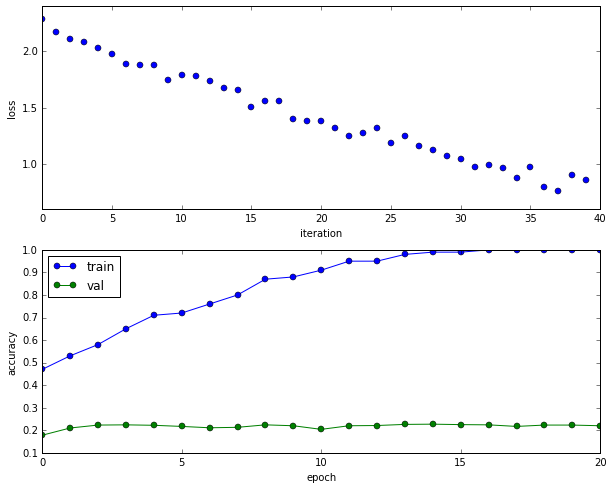

In [162]:
plt.subplot(2, 1, 1)
plt.plot(solver.loss_history, 'o')
plt.xlabel('iteration')
plt.ylabel('loss')

plt.subplot(2, 1, 2)
plt.plot(solver.train_acc_history, '-o')
plt.plot(solver.val_acc_history, '-o')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

In [204]:
model_2 = ThreeLayerConvNet(weight_scale=0.001, hidden_dim=500, reg=0.001, filter_size = 3,use_batchnorm=True)

solver_2 = Solver(model_2, data,
                num_epochs=10, batch_size=50,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-3,
                },
                verbose=True, print_every=20)
solver_2.train()

  0%|          | 0/9800 [00:00<?, ?it/s]

We use batchnorm here
(Iteration 1 / 9800) loss: 2.301807
(Epoch 0 / 10) train acc: 0.144000; val_acc: 0.138000

  0%|          | 20/9800 [00:11<1:10:00,  2.33it/s]


(Iteration 21 / 9800) loss: 2.041331

  0%|          | 40/9800 [00:20<1:08:15,  2.38it/s]


(Iteration 41 / 9800) loss: 1.793264

  1%|          | 60/9800 [00:28<1:08:16,  2.38it/s]


(Iteration 61 / 9800) loss: 1.741652

  1%|          | 80/9800 [00:37<1:09:31,  2.33it/s]


(Iteration 81 / 9800) loss: 1.676991

  1%|          | 100/9800 [00:45<1:07:36,  2.39it/s]


(Iteration 101 / 9800) loss: 1.700172

  1%|          | 120/9800 [00:54<1:09:23,  2.32it/s]


(Iteration 121 / 9800) loss: 1.574043

  1%|▏         | 140/9800 [01:02<1:07:10,  2.40it/s]


(Iteration 141 / 9800) loss: 1.615069

  2%|▏         | 160/9800 [01:11<1:08:22,  2.35it/s]


(Iteration 161 / 9800) loss: 1.743998

  2%|▏         | 180/9800 [01:19<1:07:41,  2.37it/s]


(Iteration 181 / 9800) loss: 1.772455

  2%|▏         | 200/9800 [01:28<1:07:56,  2.35it/s]


(Iteration 201 / 9800) loss: 1.693264

  2%|▏         | 220/9800 [01:36<1:07:28,  2.37it/s]


(Iteration 221 / 9800) loss: 1.623101

  2%|▏         | 240/9800 [01:45<1:07:30,  2.36it/s]


(Iteration 241 / 9800) loss: 1.377015

  3%|▎         | 260/9800 [01:53<1:07:19,  2.36it/s]


(Iteration 261 / 9800) loss: 1.655664

  3%|▎         | 280/9800 [02:02<1:08:19,  2.32it/s]


(Iteration 281 / 9800) loss: 1.806203

  3%|▎         | 300/9800 [02:10<1:07:01,  2.36it/s]


(Iteration 301 / 9800) loss: 1.296579

  3%|▎         | 320/9800 [02:19<1:07:10,  2.35it/s]


(Iteration 321 / 9800) loss: 1.732178

  3%|▎         | 340/9800 [02:28<1:06:45,  2.36it/s]


(Iteration 341 / 9800) loss: 1.715510

  4%|▎         | 360/9800 [02:36<1:07:30,  2.33it/s]


(Iteration 361 / 9800) loss: 1.766622

  4%|▍         | 380/9800 [02:45<1:07:04,  2.34it/s]


(Iteration 381 / 9800) loss: 1.326606

  4%|▍         | 400/9800 [02:53<1:06:33,  2.35it/s]


(Iteration 401 / 9800) loss: 1.890552

  4%|▍         | 420/9800 [03:02<1:06:10,  2.36it/s]


(Iteration 421 / 9800) loss: 1.514408

  4%|▍         | 440/9800 [03:10<1:06:19,  2.35it/s]


(Iteration 441 / 9800) loss: 1.449251

  5%|▍         | 460/9800 [03:19<1:06:48,  2.33it/s]


(Iteration 461 / 9800) loss: 1.499038

  5%|▍         | 480/9800 [03:28<1:13:07,  2.12it/s]


(Iteration 481 / 9800) loss: 1.403711

  5%|▌         | 500/9800 [03:37<1:05:28,  2.37it/s]


(Iteration 501 / 9800) loss: 1.762100

  5%|▌         | 520/9800 [03:45<1:05:27,  2.36it/s]


(Iteration 521 / 9800) loss: 1.381410

  6%|▌         | 540/9800 [03:54<1:06:02,  2.34it/s]


(Iteration 541 / 9800) loss: 1.676543

  6%|▌         | 560/9800 [04:02<1:05:28,  2.35it/s]


(Iteration 561 / 9800) loss: 1.589764

  6%|▌         | 580/9800 [04:11<1:05:41,  2.34it/s]


(Iteration 581 / 9800) loss: 1.644380

  6%|▌         | 600/9800 [04:19<1:05:03,  2.36it/s]


(Iteration 601 / 9800) loss: 1.695932

  6%|▋         | 620/9800 [04:28<1:05:07,  2.35it/s]


(Iteration 621 / 9800) loss: 1.466264

  7%|▋         | 640/9800 [04:36<1:04:46,  2.36it/s]


(Iteration 641 / 9800) loss: 1.461340

  7%|▋         | 660/9800 [04:45<1:04:59,  2.34it/s]


(Iteration 661 / 9800) loss: 1.439647

  7%|▋         | 680/9800 [04:53<1:04:31,  2.36it/s]


(Iteration 681 / 9800) loss: 1.520273

  7%|▋         | 700/9800 [05:02<1:04:48,  2.34it/s]


(Iteration 701 / 9800) loss: 1.534782

  7%|▋         | 720/9800 [05:11<1:03:58,  2.37it/s]


(Iteration 721 / 9800) loss: 1.354453

  8%|▊         | 740/9800 [05:19<1:03:47,  2.37it/s]


(Iteration 741 / 9800) loss: 1.951028

  8%|▊         | 760/9800 [05:28<1:03:48,  2.36it/s]


(Iteration 761 / 9800) loss: 1.436786

  8%|▊         | 780/9800 [05:36<1:04:05,  2.35it/s]


(Iteration 781 / 9800) loss: 1.240303

  8%|▊         | 800/9800 [05:45<1:04:40,  2.32it/s]


(Iteration 801 / 9800) loss: 1.498758

  8%|▊         | 820/9800 [05:53<1:03:20,  2.36it/s]


(Iteration 821 / 9800) loss: 1.472836

  9%|▊         | 840/9800 [06:02<1:05:11,  2.29it/s]


(Iteration 841 / 9800) loss: 1.361009

  9%|▉         | 860/9800 [06:10<1:03:48,  2.33it/s]


(Iteration 861 / 9800) loss: 1.830372

  9%|▉         | 880/9800 [06:19<1:03:40,  2.33it/s]


(Iteration 881 / 9800) loss: 1.384029

  9%|▉         | 900/9800 [06:27<1:03:04,  2.35it/s]


(Iteration 901 / 9800) loss: 1.310932

  9%|▉         | 920/9800 [06:36<1:02:28,  2.37it/s]


(Iteration 921 / 9800) loss: 1.774794

 10%|▉         | 940/9800 [06:44<1:02:57,  2.35it/s]


(Iteration 941 / 9800) loss: 1.399999

 10%|▉         | 960/9800 [06:53<1:01:33,  2.39it/s]


(Iteration 961 / 9800) loss: 1.378495

 10%|▉         | 979/9800 [07:01<1:03:16,  2.32it/s]


(Epoch 1 / 10) train acc: 0.618000; val_acc: 0.576000

 10%|█         | 980/9800 [07:04<3:07:35,  1.28s/it]


(Iteration 981 / 9800) loss: 1.705515

 10%|█         | 1000/9800 [07:13<1:02:55,  2.33it/s]


(Iteration 1001 / 9800) loss: 1.253174

 10%|█         | 1020/9800 [07:21<1:02:22,  2.35it/s]


(Iteration 1021 / 9800) loss: 1.695299

 11%|█         | 1040/9800 [07:30<1:02:36,  2.33it/s]


(Iteration 1041 / 9800) loss: 1.281664

 11%|█         | 1060/9800 [07:39<1:01:38,  2.36it/s]


(Iteration 1061 / 9800) loss: 1.585048

 11%|█         | 1080/9800 [07:47<1:01:34,  2.36it/s]


(Iteration 1081 / 9800) loss: 1.807965

 11%|█         | 1100/9800 [07:56<1:04:41,  2.24it/s]


(Iteration 1101 / 9800) loss: 1.510374

 11%|█▏        | 1120/9800 [08:04<1:02:18,  2.32it/s]


(Iteration 1121 / 9800) loss: 1.398008

 12%|█▏        | 1140/9800 [08:13<1:01:39,  2.34it/s]


(Iteration 1141 / 9800) loss: 1.592654

 12%|█▏        | 1160/9800 [08:21<1:02:03,  2.32it/s]


(Iteration 1161 / 9800) loss: 1.311157

 12%|█▏        | 1180/9800 [08:30<1:01:24,  2.34it/s]


(Iteration 1181 / 9800) loss: 1.706461

 12%|█▏        | 1200/9800 [08:39<1:00:43,  2.36it/s]


(Iteration 1201 / 9800) loss: 1.427372

 12%|█▏        | 1220/9800 [08:48<1:01:02,  2.34it/s]


(Iteration 1221 / 9800) loss: 1.455048

 13%|█▎        | 1240/9800 [08:56<1:01:21,  2.33it/s]


(Iteration 1241 / 9800) loss: 1.485963

 13%|█▎        | 1260/9800 [09:04<1:00:26,  2.35it/s]


(Iteration 1261 / 9800) loss: 1.210250

 13%|█▎        | 1280/9800 [09:13<1:00:21,  2.35it/s]


(Iteration 1281 / 9800) loss: 1.389270

 13%|█▎        | 1300/9800 [09:22<1:00:37,  2.34it/s]


(Iteration 1301 / 9800) loss: 1.630529

 13%|█▎        | 1320/9800 [09:30<59:49,  2.36it/s]  


(Iteration 1321 / 9800) loss: 1.369056

 14%|█▎        | 1340/9800 [09:39<59:55,  2.35it/s]  


(Iteration 1341 / 9800) loss: 1.228521

 14%|█▍        | 1360/9800 [09:47<59:58,  2.35it/s]


(Iteration 1361 / 9800) loss: 1.565931

 14%|█▍        | 1380/9800 [09:56<1:00:06,  2.33it/s]


(Iteration 1381 / 9800) loss: 1.588321

 14%|█▍        | 1400/9800 [10:04<59:59,  2.33it/s]


(Iteration 1401 / 9800) loss: 1.290568

 14%|█▍        | 1420/9800 [10:13<59:08,  2.36it/s]


(Iteration 1421 / 9800) loss: 1.139045

 15%|█▍        | 1440/9800 [10:21<59:36,  2.34it/s]


(Iteration 1441 / 9800) loss: 1.564689

 15%|█▍        | 1460/9800 [10:30<59:07,  2.35it/s]


(Iteration 1461 / 9800) loss: 1.484730

 15%|█▌        | 1480/9800 [10:38<58:55,  2.35it/s]


(Iteration 1481 / 9800) loss: 1.434124

 15%|█▌        | 1500/9800 [10:47<58:11,  2.38it/s]


(Iteration 1501 / 9800) loss: 1.592614

 16%|█▌        | 1520/9800 [10:55<58:31,  2.36it/s]


(Iteration 1521 / 9800) loss: 1.386207

 16%|█▌        | 1540/9800 [11:04<57:47,  2.38it/s]


(Iteration 1541 / 9800) loss: 1.487248

 16%|█▌        | 1560/9800 [11:12<58:16,  2.36it/s]


(Iteration 1561 / 9800) loss: 1.360271

 16%|█▌        | 1580/9800 [11:21<58:13,  2.35it/s]


(Iteration 1581 / 9800) loss: 1.593556

 16%|█▋        | 1600/9800 [11:29<57:48,  2.36it/s]


(Iteration 1601 / 9800) loss: 1.491603

 17%|█▋        | 1620/9800 [11:38<57:03,  2.39it/s]


(Iteration 1621 / 9800) loss: 1.115163

 17%|█▋        | 1640/9800 [11:46<58:17,  2.33it/s]


(Iteration 1641 / 9800) loss: 1.423779

 17%|█▋        | 1660/9800 [11:55<57:41,  2.35it/s]


(Iteration 1661 / 9800) loss: 1.526132

 17%|█▋        | 1680/9800 [12:03<57:20,  2.36it/s]


(Iteration 1681 / 9800) loss: 1.396412

 17%|█▋        | 1700/9800 [12:12<57:03,  2.37it/s]


(Iteration 1701 / 9800) loss: 1.530576

 18%|█▊        | 1720/9800 [12:20<57:12,  2.35it/s]


(Iteration 1721 / 9800) loss: 1.264831

 18%|█▊        | 1740/9800 [12:29<57:07,  2.35it/s]


(Iteration 1741 / 9800) loss: 1.604875

 18%|█▊        | 1760/9800 [12:37<56:27,  2.37it/s]


(Iteration 1761 / 9800) loss: 1.401791

 18%|█▊        | 1780/9800 [12:46<56:40,  2.36it/s]


(Iteration 1781 / 9800) loss: 1.430390

 18%|█▊        | 1800/9800 [12:54<56:08,  2.38it/s]


(Iteration 1801 / 9800) loss: 1.199159

 19%|█▊        | 1820/9800 [13:03<56:34,  2.35it/s]


(Iteration 1821 / 9800) loss: 1.500329

 19%|█▉        | 1840/9800 [13:11<59:41,  2.22it/s]  


(Iteration 1841 / 9800) loss: 1.211465

 19%|█▉        | 1860/9800 [13:21<1:03:15,  2.09it/s]


(Iteration 1861 / 9800) loss: 1.409242

 19%|█▉        | 1880/9800 [13:31<1:06:26,  1.99it/s]


(Iteration 1881 / 9800) loss: 1.571691

 19%|█▉        | 1900/9800 [13:40<56:44,  2.32it/s]


(Iteration 1901 / 9800) loss: 1.453135

 20%|█▉        | 1920/9800 [13:48<56:20,  2.33it/s]


(Iteration 1921 / 9800) loss: 1.318885

 20%|█▉        | 1940/9800 [13:58<59:00,  2.22it/s]


(Iteration 1941 / 9800) loss: 1.331449

 20%|█▉        | 1959/9800 [14:07<59:18,  2.20it/s]


(Epoch 2 / 10) train acc: 0.680000; val_acc: 0.594000

 20%|██        | 1960/9800 [14:11<3:16:58,  1.51s/it]


(Iteration 1961 / 9800) loss: 1.581854

 20%|██        | 1980/9800 [14:21<56:11,  2.32it/s]


(Iteration 1981 / 9800) loss: 1.468167

 20%|██        | 2000/9800 [14:30<54:46,  2.37it/s]


(Iteration 2001 / 9800) loss: 1.489433

 21%|██        | 2020/9800 [14:38<54:21,  2.39it/s]


(Iteration 2021 / 9800) loss: 1.573706

 21%|██        | 2040/9800 [14:47<55:26,  2.33it/s]


(Iteration 2041 / 9800) loss: 1.471938

 21%|██        | 2060/9800 [14:55<57:37,  2.24it/s]


(Iteration 2061 / 9800) loss: 1.210981

 21%|██        | 2080/9800 [15:04<55:15,  2.33it/s]


(Iteration 2081 / 9800) loss: 1.578033

 21%|██▏       | 2100/9800 [15:12<54:05,  2.37it/s]


(Iteration 2101 / 9800) loss: 1.429719

 22%|██▏       | 2120/9800 [15:21<53:35,  2.39it/s]


(Iteration 2121 / 9800) loss: 1.213516

 22%|██▏       | 2140/9800 [15:29<54:04,  2.36it/s]


(Iteration 2141 / 9800) loss: 1.303348

 22%|██▏       | 2160/9800 [15:38<53:49,  2.37it/s]


(Iteration 2161 / 9800) loss: 1.629880

 22%|██▏       | 2180/9800 [15:46<53:47,  2.36it/s]


(Iteration 2181 / 9800) loss: 1.172715

 22%|██▏       | 2200/9800 [15:55<53:49,  2.35it/s]


(Iteration 2201 / 9800) loss: 1.254197

 23%|██▎       | 2220/9800 [16:03<52:49,  2.39it/s]


(Iteration 2221 / 9800) loss: 1.223991

 23%|██▎       | 2240/9800 [16:12<52:58,  2.38it/s]


(Iteration 2241 / 9800) loss: 1.391866

 23%|██▎       | 2260/9800 [16:20<53:12,  2.36it/s]


(Iteration 2261 / 9800) loss: 1.315147

 23%|██▎       | 2280/9800 [16:29<53:18,  2.35it/s]


(Iteration 2281 / 9800) loss: 1.540310

 23%|██▎       | 2300/9800 [16:37<52:18,  2.39it/s]


(Iteration 2301 / 9800) loss: 1.369304

 24%|██▎       | 2320/9800 [16:46<51:56,  2.40it/s]


(Iteration 2321 / 9800) loss: 1.198344

 24%|██▍       | 2340/9800 [16:54<52:13,  2.38it/s]


(Iteration 2341 / 9800) loss: 1.019100

 24%|██▍       | 2360/9800 [17:02<52:40,  2.35it/s]


(Iteration 2361 / 9800) loss: 1.326461

 24%|██▍       | 2380/9800 [17:11<51:47,  2.39it/s]


(Iteration 2381 / 9800) loss: 1.286678

 24%|██▍       | 2400/9800 [17:19<52:28,  2.35it/s]


(Iteration 2401 / 9800) loss: 1.236063

 25%|██▍       | 2420/9800 [17:28<52:05,  2.36it/s]


(Iteration 2421 / 9800) loss: 1.496312

 25%|██▍       | 2440/9800 [17:36<52:06,  2.35it/s]


(Iteration 2441 / 9800) loss: 1.109708

 25%|██▌       | 2460/9800 [17:45<52:54,  2.31it/s]


(Iteration 2461 / 9800) loss: 1.299948

 25%|██▌       | 2480/9800 [17:54<52:27,  2.33it/s]


(Iteration 2481 / 9800) loss: 1.686584

 26%|██▌       | 2500/9800 [18:03<57:31,  2.12it/s]


(Iteration 2501 / 9800) loss: 1.250880

 26%|██▌       | 2520/9800 [18:11<51:18,  2.36it/s]


(Iteration 2521 / 9800) loss: 1.220808

 26%|██▌       | 2540/9800 [18:20<52:01,  2.33it/s]


(Iteration 2541 / 9800) loss: 1.041099

 26%|██▌       | 2560/9800 [18:29<51:48,  2.33it/s]


(Iteration 2561 / 9800) loss: 1.370882

 26%|██▋       | 2580/9800 [18:37<51:50,  2.32it/s]


(Iteration 2581 / 9800) loss: 1.470418

 27%|██▋       | 2600/9800 [18:46<50:19,  2.38it/s]


(Iteration 2601 / 9800) loss: 1.226550

 27%|██▋       | 2620/9800 [18:54<50:48,  2.35it/s]


(Iteration 2621 / 9800) loss: 1.193311

 27%|██▋       | 2640/9800 [19:03<50:55,  2.34it/s]


(Iteration 2641 / 9800) loss: 1.178070

 27%|██▋       | 2660/9800 [19:11<52:51,  2.25it/s]


(Iteration 2661 / 9800) loss: 1.216753

 27%|██▋       | 2680/9800 [19:20<49:50,  2.38it/s]


(Iteration 2681 / 9800) loss: 1.330286

 28%|██▊       | 2700/9800 [19:28<49:15,  2.40it/s]


(Iteration 2701 / 9800) loss: 1.263967

 28%|██▊       | 2720/9800 [19:37<49:16,  2.39it/s]


(Iteration 2721 / 9800) loss: 1.294899

 28%|██▊       | 2740/9800 [19:45<49:13,  2.39it/s]


(Iteration 2741 / 9800) loss: 1.354899

 28%|██▊       | 2760/9800 [19:53<49:26,  2.37it/s]


(Iteration 2761 / 9800) loss: 1.306986

 28%|██▊       | 2780/9800 [20:02<49:11,  2.38it/s]


(Iteration 2781 / 9800) loss: 1.492903

 29%|██▊       | 2800/9800 [20:10<48:38,  2.40it/s]


(Iteration 2801 / 9800) loss: 1.215035

 29%|██▉       | 2820/9800 [20:19<48:54,  2.38it/s]


(Iteration 2821 / 9800) loss: 1.171530

 29%|██▉       | 2840/9800 [20:27<48:59,  2.37it/s]


(Iteration 2841 / 9800) loss: 1.156879

 29%|██▉       | 2860/9800 [20:35<48:12,  2.40it/s]


(Iteration 2861 / 9800) loss: 1.309960

 29%|██▉       | 2880/9800 [20:44<48:12,  2.39it/s]


(Iteration 2881 / 9800) loss: 1.140280

 30%|██▉       | 2900/9800 [20:52<48:10,  2.39it/s]


(Iteration 2901 / 9800) loss: 1.477704

 30%|██▉       | 2920/9800 [21:01<48:04,  2.38it/s]


(Iteration 2921 / 9800) loss: 1.361262

 30%|██▉       | 2939/9800 [21:09<48:02,  2.38it/s]


(Epoch 3 / 10) train acc: 0.686000; val_acc: 0.614000

 30%|███       | 2940/9800 [21:12<2:23:24,  1.25s/it]


(Iteration 2941 / 9800) loss: 1.226993

 30%|███       | 2960/9800 [21:20<47:42,  2.39it/s]


(Iteration 2961 / 9800) loss: 1.199820

 30%|███       | 2980/9800 [21:29<47:58,  2.37it/s]


(Iteration 2981 / 9800) loss: 1.216787

 31%|███       | 3000/9800 [21:37<47:58,  2.36it/s]


(Iteration 3001 / 9800) loss: 1.104658

 31%|███       | 3020/9800 [21:46<49:10,  2.30it/s]


(Iteration 3021 / 9800) loss: 1.563841

 31%|███       | 3040/9800 [21:55<47:44,  2.36it/s]


(Iteration 3041 / 9800) loss: 1.467677

 31%|███       | 3060/9800 [22:03<47:05,  2.39it/s]


(Iteration 3061 / 9800) loss: 0.991094

 31%|███▏      | 3080/9800 [22:11<46:54,  2.39it/s]


(Iteration 3081 / 9800) loss: 1.265862

 32%|███▏      | 3100/9800 [22:20<47:08,  2.37it/s]


(Iteration 3101 / 9800) loss: 1.356920

 32%|███▏      | 3120/9800 [22:29<49:22,  2.25it/s]


(Iteration 3121 / 9800) loss: 1.419226

 32%|███▏      | 3140/9800 [22:37<47:25,  2.34it/s]


(Iteration 3141 / 9800) loss: 1.441345

 32%|███▏      | 3160/9800 [22:46<47:36,  2.32it/s]


(Iteration 3161 / 9800) loss: 1.288052

 32%|███▏      | 3180/9800 [22:54<47:33,  2.32it/s]


(Iteration 3181 / 9800) loss: 1.045625

 33%|███▎      | 3200/9800 [23:03<47:27,  2.32it/s]


(Iteration 3201 / 9800) loss: 1.123696

 33%|███▎      | 3220/9800 [23:11<47:07,  2.33it/s]


(Iteration 3221 / 9800) loss: 1.339191

 33%|███▎      | 3240/9800 [23:20<48:13,  2.27it/s]


(Iteration 3241 / 9800) loss: 1.185773

 33%|███▎      | 3260/9800 [23:28<46:08,  2.36it/s]


(Iteration 3261 / 9800) loss: 1.163636

 33%|███▎      | 3280/9800 [23:37<46:22,  2.34it/s]


(Iteration 3281 / 9800) loss: 1.431330

 34%|███▎      | 3300/9800 [23:46<45:14,  2.39it/s]


(Iteration 3301 / 9800) loss: 1.115689

 34%|███▍      | 3320/9800 [23:54<45:20,  2.38it/s]


(Iteration 3321 / 9800) loss: 1.344274

 34%|███▍      | 3340/9800 [24:03<45:49,  2.35it/s]


(Iteration 3341 / 9800) loss: 1.335475

 34%|███▍      | 3360/9800 [24:12<46:49,  2.29it/s]


(Iteration 3361 / 9800) loss: 1.355954

 34%|███▍      | 3380/9800 [24:20<45:44,  2.34it/s]


(Iteration 3381 / 9800) loss: 1.253427

 35%|███▍      | 3400/9800 [24:29<47:37,  2.24it/s]


(Iteration 3401 / 9800) loss: 1.370075

 35%|███▍      | 3420/9800 [24:38<45:32,  2.33it/s]


(Iteration 3421 / 9800) loss: 1.467437

 35%|███▌      | 3440/9800 [24:46<44:43,  2.37it/s]


(Iteration 3441 / 9800) loss: 1.177533

 35%|███▌      | 3460/9800 [24:55<44:02,  2.40it/s]


(Iteration 3461 / 9800) loss: 1.201604

 36%|███▌      | 3480/9800 [25:03<44:04,  2.39it/s]


(Iteration 3481 / 9800) loss: 1.292159

 36%|███▌      | 3500/9800 [25:11<44:01,  2.38it/s]


(Iteration 3501 / 9800) loss: 1.261203

 36%|███▌      | 3520/9800 [25:20<44:57,  2.33it/s]


(Iteration 3521 / 9800) loss: 1.109330

 36%|███▌      | 3540/9800 [25:28<44:01,  2.37it/s]


(Iteration 3541 / 9800) loss: 0.949636

 36%|███▋      | 3560/9800 [25:37<43:38,  2.38it/s]


(Iteration 3561 / 9800) loss: 1.186705

 37%|███▋      | 3580/9800 [25:46<44:00,  2.36it/s]


(Iteration 3581 / 9800) loss: 1.187180

 37%|███▋      | 3600/9800 [25:54<43:33,  2.37it/s]


(Iteration 3601 / 9800) loss: 1.221558

 37%|███▋      | 3620/9800 [26:02<42:49,  2.41it/s]


(Iteration 3621 / 9800) loss: 1.027918

 37%|███▋      | 3640/9800 [26:11<43:37,  2.35it/s]


(Iteration 3641 / 9800) loss: 1.194447

 37%|███▋      | 3660/9800 [26:19<43:11,  2.37it/s]


(Iteration 3661 / 9800) loss: 1.316152

 38%|███▊      | 3680/9800 [26:28<42:42,  2.39it/s]


(Iteration 3681 / 9800) loss: 1.163355

 38%|███▊      | 3700/9800 [26:36<43:03,  2.36it/s]


(Iteration 3701 / 9800) loss: 1.125120

 38%|███▊      | 3720/9800 [26:45<43:01,  2.36it/s]


(Iteration 3721 / 9800) loss: 1.407382

 38%|███▊      | 3740/9800 [26:53<44:16,  2.28it/s]


(Iteration 3741 / 9800) loss: 1.380331

 38%|███▊      | 3760/9800 [27:02<44:09,  2.28it/s]


(Iteration 3761 / 9800) loss: 1.265723

 39%|███▊      | 3780/9800 [27:11<44:37,  2.25it/s]


(Iteration 3781 / 9800) loss: 1.171401

 39%|███▉      | 3800/9800 [27:19<42:05,  2.38it/s]


(Iteration 3801 / 9800) loss: 1.529447

 39%|███▉      | 3820/9800 [27:28<42:51,  2.33it/s]


(Iteration 3821 / 9800) loss: 1.170069

 39%|███▉      | 3840/9800 [27:37<42:13,  2.35it/s]


(Iteration 3841 / 9800) loss: 1.016094

 39%|███▉      | 3860/9800 [27:45<42:24,  2.33it/s]


(Iteration 3861 / 9800) loss: 1.065728

 40%|███▉      | 3880/9800 [27:54<42:12,  2.34it/s]


(Iteration 3881 / 9800) loss: 1.223371

 40%|███▉      | 3900/9800 [28:02<41:23,  2.38it/s]


(Iteration 3901 / 9800) loss: 1.384511

 40%|███▉      | 3919/9800 [28:10<41:36,  2.36it/s]


(Epoch 4 / 10) train acc: 0.723000; val_acc: 0.655000

 40%|████      | 3920/9800 [28:14<2:03:20,  1.26s/it]


(Iteration 3921 / 9800) loss: 1.078849

 40%|████      | 3940/9800 [28:22<41:37,  2.35it/s]


(Iteration 3941 / 9800) loss: 1.197144

 40%|████      | 3960/9800 [28:31<41:13,  2.36it/s]


(Iteration 3961 / 9800) loss: 1.409042

 41%|████      | 3980/9800 [28:39<40:54,  2.37it/s]


(Iteration 3981 / 9800) loss: 1.254165

 41%|████      | 4000/9800 [28:48<41:56,  2.31it/s]


(Iteration 4001 / 9800) loss: 1.176814

 41%|████      | 4020/9800 [28:56<40:50,  2.36it/s]


(Iteration 4021 / 9800) loss: 1.385838

 41%|████      | 4040/9800 [29:05<40:20,  2.38it/s]


(Iteration 4041 / 9800) loss: 1.213598

 41%|████▏     | 4060/9800 [29:13<39:59,  2.39it/s]


(Iteration 4061 / 9800) loss: 1.469220

 42%|████▏     | 4080/9800 [29:22<40:35,  2.35it/s]


(Iteration 4081 / 9800) loss: 1.288780

 42%|████▏     | 4100/9800 [29:30<40:35,  2.34it/s]


(Iteration 4101 / 9800) loss: 1.128769

 42%|████▏     | 4120/9800 [29:39<40:18,  2.35it/s]


(Iteration 4121 / 9800) loss: 1.125632

 42%|████▏     | 4140/9800 [29:47<40:01,  2.36it/s]


(Iteration 4141 / 9800) loss: 1.024006

 42%|████▏     | 4160/9800 [29:56<41:25,  2.27it/s]


(Iteration 4161 / 9800) loss: 1.250637

 43%|████▎     | 4180/9800 [30:04<39:44,  2.36it/s]


(Iteration 4181 / 9800) loss: 1.248958

 43%|████▎     | 4200/9800 [30:13<39:06,  2.39it/s]


(Iteration 4201 / 9800) loss: 1.209278

 43%|████▎     | 4220/9800 [30:22<40:18,  2.31it/s]


(Iteration 4221 / 9800) loss: 1.115384

 43%|████▎     | 4240/9800 [30:30<38:51,  2.38it/s]


(Iteration 4241 / 9800) loss: 1.357166

 43%|████▎     | 4260/9800 [30:38<38:41,  2.39it/s]


(Iteration 4261 / 9800) loss: 1.090234

 44%|████▎     | 4280/9800 [30:47<39:17,  2.34it/s]


(Iteration 4281 / 9800) loss: 1.145743

 44%|████▍     | 4300/9800 [30:55<38:45,  2.37it/s]


(Iteration 4301 / 9800) loss: 1.290674

 44%|████▍     | 4320/9800 [31:04<38:40,  2.36it/s]


(Iteration 4321 / 9800) loss: 1.041827

 44%|████▍     | 4340/9800 [31:12<38:32,  2.36it/s]


(Iteration 4341 / 9800) loss: 1.388325

 44%|████▍     | 4360/9800 [31:21<38:34,  2.35it/s]


(Iteration 4361 / 9800) loss: 1.357757

 45%|████▍     | 4380/9800 [31:29<38:06,  2.37it/s]


(Iteration 4381 / 9800) loss: 1.166795

 45%|████▍     | 4400/9800 [31:38<37:41,  2.39it/s]


(Iteration 4401 / 9800) loss: 1.036320

 45%|████▌     | 4420/9800 [31:46<37:33,  2.39it/s]


(Iteration 4421 / 9800) loss: 1.246689

 45%|████▌     | 4440/9800 [31:55<37:58,  2.35it/s]


(Iteration 4441 / 9800) loss: 0.900779

 46%|████▌     | 4460/9800 [32:03<37:25,  2.38it/s]


(Iteration 4461 / 9800) loss: 1.006484

 46%|████▌     | 4480/9800 [32:12<37:06,  2.39it/s]


(Iteration 4481 / 9800) loss: 1.225189

 46%|████▌     | 4500/9800 [32:20<36:49,  2.40it/s]


(Iteration 4501 / 9800) loss: 1.221049

 46%|████▌     | 4520/9800 [32:28<36:33,  2.41it/s]


(Iteration 4521 / 9800) loss: 1.453777

 46%|████▋     | 4540/9800 [32:37<36:42,  2.39it/s]


(Iteration 4541 / 9800) loss: 1.088238

 47%|████▋     | 4560/9800 [32:45<37:01,  2.36it/s]


(Iteration 4561 / 9800) loss: 1.132150

 47%|████▋     | 4580/9800 [32:54<36:33,  2.38it/s]


(Iteration 4581 / 9800) loss: 1.566932

 47%|████▋     | 4600/9800 [33:02<36:18,  2.39it/s]


(Iteration 4601 / 9800) loss: 1.031385

 47%|████▋     | 4620/9800 [33:10<36:03,  2.39it/s]


(Iteration 4621 / 9800) loss: 1.194771

 47%|████▋     | 4640/9800 [33:19<36:17,  2.37it/s]


(Iteration 4641 / 9800) loss: 1.292530

 48%|████▊     | 4660/9800 [33:27<36:09,  2.37it/s]


(Iteration 4661 / 9800) loss: 1.195475

 48%|████▊     | 4680/9800 [33:36<35:35,  2.40it/s]


(Iteration 4681 / 9800) loss: 1.163213

 48%|████▊     | 4700/9800 [33:45<53:02,  1.60it/s]


(Iteration 4701 / 9800) loss: 1.049115

 48%|████▊     | 4720/9800 [34:15<59:51,  1.41it/s]  


(Iteration 4721 / 9800) loss: 0.858720

 48%|████▊     | 4740/9800 [34:27<36:17,  2.32it/s]


(Iteration 4741 / 9800) loss: 1.162491

 49%|████▊     | 4760/9800 [34:35<34:46,  2.42it/s]


(Iteration 4761 / 9800) loss: 1.112683

 49%|████▉     | 4780/9800 [34:44<35:52,  2.33it/s]


(Iteration 4781 / 9800) loss: 1.150962

 49%|████▉     | 4800/9800 [34:52<34:56,  2.39it/s]


(Iteration 4801 / 9800) loss: 1.128325

 49%|████▉     | 4820/9800 [35:00<34:21,  2.42it/s]


(Iteration 4821 / 9800) loss: 1.049787

 49%|████▉     | 4840/9800 [35:09<34:47,  2.38it/s]


(Iteration 4841 / 9800) loss: 1.153787

 50%|████▉     | 4860/9800 [35:17<35:32,  2.32it/s]


(Iteration 4861 / 9800) loss: 1.120583

 50%|████▉     | 4880/9800 [35:26<35:52,  2.29it/s]


(Iteration 4881 / 9800) loss: 1.204308

 50%|████▉     | 4899/9800 [35:37<44:31,  1.83it/s]


(Epoch 5 / 10) train acc: 0.726000; val_acc: 0.640000

 50%|█████     | 4900/9800 [35:40<1:49:46,  1.34s/it]


(Iteration 4901 / 9800) loss: 1.288441

 50%|█████     | 4920/9800 [35:48<33:53,  2.40it/s]


(Iteration 4921 / 9800) loss: 1.271065

 50%|█████     | 4940/9800 [35:57<33:36,  2.41it/s]


(Iteration 4941 / 9800) loss: 1.335461

 51%|█████     | 4960/9800 [36:05<33:50,  2.38it/s]


(Iteration 4961 / 9800) loss: 1.463313

 51%|█████     | 4980/9800 [36:14<34:04,  2.36it/s]


(Iteration 4981 / 9800) loss: 1.413283

 51%|█████     | 5000/9800 [36:22<33:59,  2.35it/s]


(Iteration 5001 / 9800) loss: 1.208479

 51%|█████     | 5020/9800 [36:30<33:37,  2.37it/s]


(Iteration 5021 / 9800) loss: 1.310918

 51%|█████▏    | 5040/9800 [36:39<33:30,  2.37it/s]


(Iteration 5041 / 9800) loss: 1.127482

 52%|█████▏    | 5060/9800 [36:47<33:02,  2.39it/s]


(Iteration 5061 / 9800) loss: 1.041333

 52%|█████▏    | 5080/9800 [36:56<33:17,  2.36it/s]


(Iteration 5081 / 9800) loss: 1.197200

 52%|█████▏    | 5100/9800 [37:04<33:06,  2.37it/s]


(Iteration 5101 / 9800) loss: 1.246288

 52%|█████▏    | 5120/9800 [37:12<32:40,  2.39it/s]


(Iteration 5121 / 9800) loss: 1.051514

 52%|█████▏    | 5140/9800 [37:21<32:22,  2.40it/s]


(Iteration 5141 / 9800) loss: 1.035501

 53%|█████▎    | 5160/9800 [37:29<32:18,  2.39it/s]


(Iteration 5161 / 9800) loss: 0.967466

 53%|█████▎    | 5180/9800 [37:37<31:42,  2.43it/s]


(Iteration 5181 / 9800) loss: 0.990377

 53%|█████▎    | 5200/9800 [37:46<31:39,  2.42it/s]


(Iteration 5201 / 9800) loss: 1.194663

 53%|█████▎    | 5220/9800 [37:54<31:24,  2.43it/s]


(Iteration 5221 / 9800) loss: 1.430600

 53%|█████▎    | 5240/9800 [38:02<31:21,  2.42it/s]


(Iteration 5241 / 9800) loss: 1.572060

 54%|█████▎    | 5260/9800 [38:11<31:37,  2.39it/s]


(Iteration 5261 / 9800) loss: 1.227772

 54%|█████▍    | 5280/9800 [38:19<31:25,  2.40it/s]


(Iteration 5281 / 9800) loss: 1.114810

 54%|█████▍    | 5300/9800 [38:27<31:17,  2.40it/s]


(Iteration 5301 / 9800) loss: 0.917119

 54%|█████▍    | 5320/9800 [38:36<31:13,  2.39it/s]


(Iteration 5321 / 9800) loss: 0.948951

 54%|█████▍    | 5340/9800 [38:44<31:10,  2.38it/s]


(Iteration 5341 / 9800) loss: 1.267792

 55%|█████▍    | 5360/9800 [38:52<30:34,  2.42it/s]


(Iteration 5361 / 9800) loss: 1.043000

 55%|█████▍    | 5380/9800 [39:01<31:02,  2.37it/s]


(Iteration 5381 / 9800) loss: 1.086234

 55%|█████▌    | 5400/9800 [39:09<30:25,  2.41it/s]


(Iteration 5401 / 9800) loss: 0.923481

 55%|█████▌    | 5420/9800 [39:17<30:18,  2.41it/s]


(Iteration 5421 / 9800) loss: 1.138501

 56%|█████▌    | 5440/9800 [39:26<30:28,  2.38it/s]


(Iteration 5441 / 9800) loss: 1.269575

 56%|█████▌    | 5460/9800 [39:34<30:05,  2.40it/s]


(Iteration 5461 / 9800) loss: 0.950270

 56%|█████▌    | 5480/9800 [39:42<29:44,  2.42it/s]


(Iteration 5481 / 9800) loss: 1.038743

 56%|█████▌    | 5500/9800 [39:51<29:39,  2.42it/s]


(Iteration 5501 / 9800) loss: 1.028119

 56%|█████▋    | 5520/9800 [39:59<29:30,  2.42it/s]


(Iteration 5521 / 9800) loss: 1.087196

 57%|█████▋    | 5540/9800 [40:07<29:22,  2.42it/s]


(Iteration 5541 / 9800) loss: 0.961273

 57%|█████▋    | 5560/9800 [40:16<29:28,  2.40it/s]


(Iteration 5561 / 9800) loss: 1.287236

 57%|█████▋    | 5580/9800 [40:24<29:15,  2.40it/s]


(Iteration 5581 / 9800) loss: 1.111165

 57%|█████▋    | 5600/9800 [40:32<29:24,  2.38it/s]


(Iteration 5601 / 9800) loss: 1.290395

 57%|█████▋    | 5620/9800 [40:41<29:01,  2.40it/s]


(Iteration 5621 / 9800) loss: 1.191302

 58%|█████▊    | 5640/9800 [40:49<28:32,  2.43it/s]


(Iteration 5641 / 9800) loss: 1.181892

 58%|█████▊    | 5660/9800 [40:57<28:37,  2.41it/s]


(Iteration 5661 / 9800) loss: 0.825750

 58%|█████▊    | 5680/9800 [41:05<28:22,  2.42it/s]


(Iteration 5681 / 9800) loss: 1.058112

 58%|█████▊    | 5700/9800 [41:14<28:13,  2.42it/s]


(Iteration 5701 / 9800) loss: 0.934532

 58%|█████▊    | 5720/9800 [41:22<27:57,  2.43it/s]


(Iteration 5721 / 9800) loss: 1.121454

 59%|█████▊    | 5740/9800 [41:30<27:49,  2.43it/s]


(Iteration 5741 / 9800) loss: 1.530633

 59%|█████▉    | 5760/9800 [41:39<27:52,  2.42it/s]


(Iteration 5761 / 9800) loss: 1.207287

 59%|█████▉    | 5780/9800 [41:47<27:36,  2.43it/s]


(Iteration 5781 / 9800) loss: 0.993029

 59%|█████▉    | 5800/9800 [41:55<27:38,  2.41it/s]


(Iteration 5801 / 9800) loss: 0.924863

 59%|█████▉    | 5820/9800 [42:03<27:36,  2.40it/s]


(Iteration 5821 / 9800) loss: 1.162337

 60%|█████▉    | 5840/9800 [42:12<27:47,  2.38it/s]


(Iteration 5841 / 9800) loss: 1.005322

 60%|█████▉    | 5860/9800 [42:20<27:28,  2.39it/s]


(Iteration 5861 / 9800) loss: 1.155540

 60%|█████▉    | 5879/9800 [42:28<27:20,  2.39it/s]


(Epoch 6 / 10) train acc: 0.783000; val_acc: 0.667000

 60%|██████    | 5880/9800 [42:31<1:20:42,  1.24s/it]


(Iteration 5881 / 9800) loss: 0.918295

 60%|██████    | 5900/9800 [42:40<27:23,  2.37it/s]


(Iteration 5901 / 9800) loss: 0.988341

 60%|██████    | 5920/9800 [42:48<26:37,  2.43it/s]


(Iteration 5921 / 9800) loss: 1.078848

 61%|██████    | 5940/9800 [42:56<26:47,  2.40it/s]


(Iteration 5941 / 9800) loss: 0.961869

 61%|██████    | 5960/9800 [43:05<26:36,  2.41it/s]


(Iteration 5961 / 9800) loss: 0.915545

 61%|██████    | 5980/9800 [43:13<28:37,  2.22it/s]


(Iteration 5981 / 9800) loss: 1.023514

 61%|██████    | 6000/9800 [43:22<27:08,  2.33it/s]


(Iteration 6001 / 9800) loss: 1.171665

 61%|██████▏   | 6020/9800 [43:30<26:28,  2.38it/s]


(Iteration 6021 / 9800) loss: 1.160853

 62%|██████▏   | 6040/9800 [43:39<27:07,  2.31it/s]


(Iteration 6041 / 9800) loss: 1.057728

 62%|██████▏   | 6060/9800 [43:47<27:06,  2.30it/s]


(Iteration 6061 / 9800) loss: 1.071989

 62%|██████▏   | 6080/9800 [43:56<26:12,  2.37it/s]


(Iteration 6081 / 9800) loss: 1.279808

 62%|██████▏   | 6100/9800 [44:05<26:28,  2.33it/s]


(Iteration 6101 / 9800) loss: 0.955473

 62%|██████▏   | 6120/9800 [44:13<27:15,  2.25it/s]


(Iteration 6121 / 9800) loss: 0.922402

 63%|██████▎   | 6140/9800 [44:22<26:12,  2.33it/s]


(Iteration 6141 / 9800) loss: 1.205341

 63%|██████▎   | 6160/9800 [44:30<25:10,  2.41it/s]


(Iteration 6161 / 9800) loss: 1.223161

 63%|██████▎   | 6180/9800 [44:39<24:50,  2.43it/s]


(Iteration 6181 / 9800) loss: 1.133940

 63%|██████▎   | 6200/9800 [44:47<24:52,  2.41it/s]


(Iteration 6201 / 9800) loss: 1.151906

 63%|██████▎   | 6220/9800 [44:55<24:50,  2.40it/s]


(Iteration 6221 / 9800) loss: 1.175054

 64%|██████▎   | 6240/9800 [45:03<24:31,  2.42it/s]


(Iteration 6241 / 9800) loss: 1.150180

 64%|██████▍   | 6260/9800 [45:12<24:31,  2.41it/s]


(Iteration 6261 / 9800) loss: 0.995900

 64%|██████▍   | 6280/9800 [45:20<24:05,  2.44it/s]


(Iteration 6281 / 9800) loss: 1.009946

 64%|██████▍   | 6300/9800 [45:28<24:22,  2.39it/s]


(Iteration 6301 / 9800) loss: 1.171981

 64%|██████▍   | 6320/9800 [45:37<24:27,  2.37it/s]


(Iteration 6321 / 9800) loss: 1.047150

 65%|██████▍   | 6340/9800 [45:45<23:47,  2.42it/s]


(Iteration 6341 / 9800) loss: 1.337011

 65%|██████▍   | 6360/9800 [45:53<23:38,  2.43it/s]


(Iteration 6361 / 9800) loss: 1.337129

 65%|██████▌   | 6380/9800 [46:02<23:42,  2.40it/s]


(Iteration 6381 / 9800) loss: 0.971439

 65%|██████▌   | 6400/9800 [46:10<23:17,  2.43it/s]


(Iteration 6401 / 9800) loss: 1.017949

 66%|██████▌   | 6420/9800 [46:18<23:33,  2.39it/s]


(Iteration 6421 / 9800) loss: 1.048074

 66%|██████▌   | 6440/9800 [46:27<23:17,  2.41it/s]


(Iteration 6441 / 9800) loss: 0.916903

 66%|██████▌   | 6460/9800 [46:35<23:03,  2.41it/s]


(Iteration 6461 / 9800) loss: 1.030433

 66%|██████▌   | 6480/9800 [46:44<23:02,  2.40it/s]


(Iteration 6481 / 9800) loss: 1.113101

 66%|██████▋   | 6500/9800 [46:52<22:50,  2.41it/s]


(Iteration 6501 / 9800) loss: 1.165159

 67%|██████▋   | 6520/9800 [47:00<22:36,  2.42it/s]


(Iteration 6521 / 9800) loss: 1.098125

 67%|██████▋   | 6540/9800 [47:08<22:29,  2.42it/s]


(Iteration 6541 / 9800) loss: 1.023097

 67%|██████▋   | 6560/9800 [47:17<22:18,  2.42it/s]


(Iteration 6561 / 9800) loss: 0.943063

 67%|██████▋   | 6580/9800 [47:25<22:27,  2.39it/s]


(Iteration 6581 / 9800) loss: 1.305835

 67%|██████▋   | 6600/9800 [47:33<22:07,  2.41it/s]


(Iteration 6601 / 9800) loss: 1.087389

 68%|██████▊   | 6620/9800 [47:42<22:15,  2.38it/s]


(Iteration 6621 / 9800) loss: 0.899910

 68%|██████▊   | 6640/9800 [47:50<21:39,  2.43it/s]


(Iteration 6641 / 9800) loss: 0.837959

 68%|██████▊   | 6660/9800 [47:58<21:47,  2.40it/s]


(Iteration 6661 / 9800) loss: 1.328076

 68%|██████▊   | 6680/9800 [48:07<21:33,  2.41it/s]


(Iteration 6681 / 9800) loss: 0.992772

 68%|██████▊   | 6700/9800 [48:15<21:34,  2.39it/s]


(Iteration 6701 / 9800) loss: 1.175494

 69%|██████▊   | 6720/9800 [48:23<21:09,  2.43it/s]


(Iteration 6721 / 9800) loss: 1.519009

 69%|██████▉   | 6740/9800 [48:32<21:04,  2.42it/s]


(Iteration 6741 / 9800) loss: 0.916991

 69%|██████▉   | 6760/9800 [48:40<21:06,  2.40it/s]


(Iteration 6761 / 9800) loss: 1.027609

 69%|██████▉   | 6780/9800 [48:48<21:01,  2.39it/s]


(Iteration 6781 / 9800) loss: 1.000015

 69%|██████▉   | 6800/9800 [48:56<20:39,  2.42it/s]


(Iteration 6801 / 9800) loss: 0.953473

 70%|██████▉   | 6820/9800 [49:05<20:37,  2.41it/s]


(Iteration 6821 / 9800) loss: 1.294100

 70%|██████▉   | 6840/9800 [49:13<20:22,  2.42it/s]


(Iteration 6841 / 9800) loss: 1.007584

 70%|██████▉   | 6859/9800 [49:21<20:22,  2.41it/s]


(Epoch 7 / 10) train acc: 0.772000; val_acc: 0.654000

 70%|███████   | 6860/9800 [49:24<59:46,  1.22s/it]


(Iteration 6861 / 9800) loss: 1.030470

 70%|███████   | 6880/9800 [49:32<20:20,  2.39it/s]


(Iteration 6881 / 9800) loss: 1.182758

 70%|███████   | 6900/9800 [49:41<20:12,  2.39it/s]


(Iteration 6901 / 9800) loss: 0.761166

 71%|███████   | 6920/9800 [49:49<19:55,  2.41it/s]


(Iteration 6921 / 9800) loss: 1.237812

 71%|███████   | 6940/9800 [49:57<19:49,  2.40it/s]


(Iteration 6941 / 9800) loss: 0.947812

 71%|███████   | 6960/9800 [50:06<19:31,  2.42it/s]


(Iteration 6961 / 9800) loss: 0.811340

 71%|███████   | 6980/9800 [50:14<20:02,  2.35it/s]


(Iteration 6981 / 9800) loss: 1.251512

 71%|███████▏  | 7000/9800 [50:22<19:11,  2.43it/s]


(Iteration 7001 / 9800) loss: 1.098745

 72%|███████▏  | 7020/9800 [50:31<19:12,  2.41it/s]


(Iteration 7021 / 9800) loss: 1.051727

 72%|███████▏  | 7040/9800 [50:39<19:06,  2.41it/s]


(Iteration 7041 / 9800) loss: 1.124059

 72%|███████▏  | 7060/9800 [50:47<19:07,  2.39it/s]


(Iteration 7061 / 9800) loss: 1.228149

 72%|███████▏  | 7080/9800 [50:56<18:42,  2.42it/s]


(Iteration 7081 / 9800) loss: 1.042706

 72%|███████▏  | 7100/9800 [51:04<18:46,  2.40it/s]


(Iteration 7101 / 9800) loss: 0.927224

 73%|███████▎  | 7120/9800 [51:12<18:37,  2.40it/s]


(Iteration 7121 / 9800) loss: 0.968677

 73%|███████▎  | 7140/9800 [51:21<18:27,  2.40it/s]


(Iteration 7141 / 9800) loss: 0.915460

 73%|███████▎  | 7160/9800 [51:29<18:14,  2.41it/s]


(Iteration 7161 / 9800) loss: 1.304091

 73%|███████▎  | 7180/9800 [51:37<17:58,  2.43it/s]


(Iteration 7181 / 9800) loss: 0.874521

 73%|███████▎  | 7200/9800 [51:45<17:48,  2.43it/s]


(Iteration 7201 / 9800) loss: 1.036514

 74%|███████▎  | 7220/9800 [51:54<17:53,  2.40it/s]


(Iteration 7221 / 9800) loss: 0.986532

 74%|███████▍  | 7240/9800 [52:02<17:42,  2.41it/s]


(Iteration 7241 / 9800) loss: 1.068093

 74%|███████▍  | 7260/9800 [52:10<17:36,  2.40it/s]


(Iteration 7261 / 9800) loss: 1.479129

 74%|███████▍  | 7280/9800 [52:19<17:33,  2.39it/s]


(Iteration 7281 / 9800) loss: 1.304893

 74%|███████▍  | 7300/9800 [52:27<17:16,  2.41it/s]


(Iteration 7301 / 9800) loss: 1.068299

 75%|███████▍  | 7320/9800 [52:35<17:06,  2.42it/s]


(Iteration 7321 / 9800) loss: 1.031636

 75%|███████▍  | 7340/9800 [52:44<17:14,  2.38it/s]


(Iteration 7341 / 9800) loss: 1.004195

 75%|███████▌  | 7360/9800 [52:52<16:58,  2.40it/s]


(Iteration 7361 / 9800) loss: 1.284980

 75%|███████▌  | 7380/9800 [53:00<16:40,  2.42it/s]


(Iteration 7381 / 9800) loss: 1.078555

 76%|███████▌  | 7400/9800 [53:09<16:43,  2.39it/s]


(Iteration 7401 / 9800) loss: 0.923450

 76%|███████▌  | 7420/9800 [53:17<16:26,  2.41it/s]


(Iteration 7421 / 9800) loss: 1.188703

 76%|███████▌  | 7440/9800 [53:25<16:14,  2.42it/s]


(Iteration 7441 / 9800) loss: 0.890880

 76%|███████▌  | 7460/9800 [53:34<16:12,  2.41it/s]


(Iteration 7461 / 9800) loss: 1.164805

 76%|███████▋  | 7480/9800 [53:42<16:03,  2.41it/s]


(Iteration 7481 / 9800) loss: 0.945032

 77%|███████▋  | 7500/9800 [53:50<16:00,  2.39it/s]


(Iteration 7501 / 9800) loss: 1.268420

 77%|███████▋  | 7520/9800 [53:58<15:44,  2.41it/s]


(Iteration 7521 / 9800) loss: 1.404109

 77%|███████▋  | 7540/9800 [54:07<15:33,  2.42it/s]


(Iteration 7541 / 9800) loss: 0.838550

 77%|███████▋  | 7560/9800 [54:15<15:54,  2.35it/s]


(Iteration 7561 / 9800) loss: 1.064917

 77%|███████▋  | 7580/9800 [54:23<15:25,  2.40it/s]


(Iteration 7581 / 9800) loss: 0.825570

 78%|███████▊  | 7600/9800 [54:32<15:16,  2.40it/s]


(Iteration 7601 / 9800) loss: 0.947786

 78%|███████▊  | 7620/9800 [54:40<15:07,  2.40it/s]


(Iteration 7621 / 9800) loss: 1.224832

 78%|███████▊  | 7640/9800 [54:48<14:56,  2.41it/s]


(Iteration 7641 / 9800) loss: 0.893792

 78%|███████▊  | 7660/9800 [54:57<14:53,  2.40it/s]


(Iteration 7661 / 9800) loss: 0.925370

 78%|███████▊  | 7680/9800 [55:05<14:42,  2.40it/s]


(Iteration 7681 / 9800) loss: 0.845978

 79%|███████▊  | 7700/9800 [55:13<14:38,  2.39it/s]


(Iteration 7701 / 9800) loss: 0.922194

 79%|███████▉  | 7720/9800 [55:22<14:36,  2.37it/s]


(Iteration 7721 / 9800) loss: 0.943497

 79%|███████▉  | 7740/9800 [55:30<14:21,  2.39it/s]


(Iteration 7741 / 9800) loss: 1.023192

 79%|███████▉  | 7760/9800 [55:38<14:07,  2.41it/s]


(Iteration 7761 / 9800) loss: 1.069994

 79%|███████▉  | 7780/9800 [55:47<14:01,  2.40it/s]


(Iteration 7781 / 9800) loss: 0.861194

 80%|███████▉  | 7800/9800 [55:55<13:49,  2.41it/s]


(Iteration 7801 / 9800) loss: 1.096763

 80%|███████▉  | 7820/9800 [56:03<13:40,  2.41it/s]


(Iteration 7821 / 9800) loss: 0.947418

 80%|███████▉  | 7839/9800 [56:11<13:35,  2.40it/s]


(Epoch 8 / 10) train acc: 0.798000; val_acc: 0.656000

 80%|████████  | 7840/9800 [56:14<40:37,  1.24s/it]


(Iteration 7841 / 9800) loss: 1.301483

 80%|████████  | 7860/9800 [56:23<13:35,  2.38it/s]


(Iteration 7861 / 9800) loss: 0.992832

 80%|████████  | 7880/9800 [56:31<13:27,  2.38it/s]


(Iteration 7881 / 9800) loss: 1.106830

 81%|████████  | 7900/9800 [56:40<13:17,  2.38it/s]


(Iteration 7901 / 9800) loss: 0.728402

 81%|████████  | 7920/9800 [56:48<13:16,  2.36it/s]


(Iteration 7921 / 9800) loss: 0.750474

 81%|████████  | 7940/9800 [56:56<12:49,  2.42it/s]


(Iteration 7941 / 9800) loss: 0.983785

 81%|████████  | 7960/9800 [57:05<12:46,  2.40it/s]


(Iteration 7961 / 9800) loss: 0.967965

 81%|████████▏ | 7980/9800 [57:13<12:40,  2.39it/s]


(Iteration 7981 / 9800) loss: 1.292617

 82%|████████▏ | 8000/9800 [57:21<12:32,  2.39it/s]


(Iteration 8001 / 9800) loss: 1.130924

 82%|████████▏ | 8020/9800 [57:30<12:14,  2.42it/s]


(Iteration 8021 / 9800) loss: 1.145392

 82%|████████▏ | 8040/9800 [57:38<12:18,  2.38it/s]


(Iteration 8041 / 9800) loss: 0.948813

 82%|████████▏ | 8060/9800 [57:46<11:58,  2.42it/s]


(Iteration 8061 / 9800) loss: 0.942813

 82%|████████▏ | 8080/9800 [57:55<11:52,  2.41it/s]


(Iteration 8081 / 9800) loss: 0.950149

 83%|████████▎ | 8100/9800 [58:03<11:49,  2.40it/s]


(Iteration 8101 / 9800) loss: 0.989686

 83%|████████▎ | 8120/9800 [58:11<11:37,  2.41it/s]


(Iteration 8121 / 9800) loss: 0.976052

 83%|████████▎ | 8140/9800 [58:20<11:29,  2.41it/s]


(Iteration 8141 / 9800) loss: 1.028719

 83%|████████▎ | 8160/9800 [58:28<11:18,  2.42it/s]


(Iteration 8161 / 9800) loss: 1.139820

 83%|████████▎ | 8180/9800 [58:36<11:13,  2.41it/s]


(Iteration 8181 / 9800) loss: 1.127663

 84%|████████▎ | 8200/9800 [58:45<11:10,  2.39it/s]


(Iteration 8201 / 9800) loss: 0.897238

 84%|████████▍ | 8220/9800 [58:53<11:04,  2.38it/s]


(Iteration 8221 / 9800) loss: 1.147106

 84%|████████▍ | 8240/9800 [59:01<10:52,  2.39it/s]


(Iteration 8241 / 9800) loss: 1.011505

 84%|████████▍ | 8260/9800 [59:10<10:41,  2.40it/s]


(Iteration 8261 / 9800) loss: 0.984623

 84%|████████▍ | 8280/9800 [59:18<10:36,  2.39it/s]


(Iteration 8281 / 9800) loss: 0.924807

 85%|████████▍ | 8300/9800 [59:26<10:23,  2.40it/s]


(Iteration 8301 / 9800) loss: 1.039127

 85%|████████▍ | 8320/9800 [59:35<10:14,  2.41it/s]


(Iteration 8321 / 9800) loss: 1.226261

 85%|████████▌ | 8340/9800 [59:43<10:08,  2.40it/s]


(Iteration 8341 / 9800) loss: 0.925640

 85%|████████▌ | 8360/9800 [59:52<10:25,  2.30it/s]


(Iteration 8361 / 9800) loss: 1.026626

 86%|████████▌ | 8380/9800 [1:00:00<09:54,  2.39it/s]


(Iteration 8381 / 9800) loss: 1.081116

 86%|████████▌ | 8400/9800 [1:00:08<09:38,  2.42it/s]


(Iteration 8401 / 9800) loss: 0.846500

 86%|████████▌ | 8420/9800 [1:00:17<09:50,  2.34it/s]


(Iteration 8421 / 9800) loss: 0.963369

 86%|████████▌ | 8440/9800 [1:00:25<09:28,  2.39it/s]


(Iteration 8441 / 9800) loss: 0.734328

 86%|████████▋ | 8460/9800 [1:00:33<09:14,  2.42it/s]


(Iteration 8461 / 9800) loss: 0.889578

 87%|████████▋ | 8480/9800 [1:00:42<09:04,  2.42it/s]


(Iteration 8481 / 9800) loss: 1.040622

 87%|████████▋ | 8500/9800 [1:00:50<09:05,  2.38it/s]


(Iteration 8501 / 9800) loss: 0.808853

 87%|████████▋ | 8520/9800 [1:00:59<08:58,  2.38it/s]


(Iteration 8521 / 9800) loss: 1.019573

 87%|████████▋ | 8540/9800 [1:01:08<08:46,  2.39it/s]


(Iteration 8541 / 9800) loss: 1.050524

 87%|████████▋ | 8560/9800 [1:01:16<08:40,  2.38it/s]


(Iteration 8561 / 9800) loss: 0.927453

 88%|████████▊ | 8580/9800 [1:01:25<08:26,  2.41it/s]


(Iteration 8581 / 9800) loss: 0.980007

 88%|████████▊ | 8600/9800 [1:01:33<08:23,  2.38it/s]


(Iteration 8601 / 9800) loss: 0.939231

 88%|████████▊ | 8620/9800 [1:01:41<08:16,  2.38it/s]


(Iteration 8621 / 9800) loss: 1.315780

 88%|████████▊ | 8640/9800 [1:01:50<08:08,  2.38it/s]


(Iteration 8641 / 9800) loss: 1.005362

 88%|████████▊ | 8660/9800 [1:01:58<07:55,  2.40it/s]


(Iteration 8661 / 9800) loss: 1.047535

 89%|████████▊ | 8680/9800 [1:02:06<07:49,  2.39it/s]


(Iteration 8681 / 9800) loss: 0.907385

 89%|████████▉ | 8700/9800 [1:02:15<07:37,  2.41it/s]


(Iteration 8701 / 9800) loss: 1.337020

 89%|████████▉ | 8720/9800 [1:02:23<07:30,  2.40it/s]


(Iteration 8721 / 9800) loss: 0.912148

 89%|████████▉ | 8740/9800 [1:02:32<07:18,  2.42it/s]


(Iteration 8741 / 9800) loss: 0.807060

 89%|████████▉ | 8760/9800 [1:02:40<07:10,  2.42it/s]


(Iteration 8761 / 9800) loss: 1.067573

 90%|████████▉ | 8780/9800 [1:02:48<07:05,  2.39it/s]


(Iteration 8781 / 9800) loss: 1.031616

 90%|████████▉ | 8800/9800 [1:02:56<06:56,  2.40it/s]


(Iteration 8801 / 9800) loss: 0.909771

 90%|████████▉ | 8819/9800 [1:03:04<06:45,  2.42it/s]


(Epoch 9 / 10) train acc: 0.777000; val_acc: 0.662000

 90%|█████████ | 8820/9800 [1:03:07<20:04,  1.23s/it]


(Iteration 8821 / 9800) loss: 1.100927

 90%|█████████ | 8840/9800 [1:03:16<06:45,  2.37it/s]


(Iteration 8841 / 9800) loss: 1.122369

 90%|█████████ | 8860/9800 [1:03:24<06:34,  2.38it/s]


(Iteration 8861 / 9800) loss: 0.971307

 91%|█████████ | 8880/9800 [1:03:32<06:21,  2.41it/s]


(Iteration 8881 / 9800) loss: 1.174752

 91%|█████████ | 8900/9800 [1:03:41<06:15,  2.40it/s]


(Iteration 8901 / 9800) loss: 0.928658

 91%|█████████ | 8920/9800 [1:03:49<06:01,  2.43it/s]


(Iteration 8921 / 9800) loss: 1.218505

 91%|█████████ | 8940/9800 [1:03:57<06:00,  2.38it/s]


(Iteration 8941 / 9800) loss: 0.836666

 91%|█████████▏| 8960/9800 [1:04:06<05:47,  2.42it/s]


(Iteration 8961 / 9800) loss: 1.159670

 92%|█████████▏| 8980/9800 [1:04:14<05:41,  2.40it/s]


(Iteration 8981 / 9800) loss: 0.929943

 92%|█████████▏| 9000/9800 [1:04:22<05:31,  2.41it/s]


(Iteration 9001 / 9800) loss: 0.930890

 92%|█████████▏| 9020/9800 [1:04:31<05:24,  2.40it/s]


(Iteration 9021 / 9800) loss: 0.736098

 92%|█████████▏| 9040/9800 [1:04:39<05:18,  2.39it/s]


(Iteration 9041 / 9800) loss: 0.982869

 92%|█████████▏| 9060/9800 [1:04:47<05:07,  2.41it/s]


(Iteration 9061 / 9800) loss: 1.036962

 93%|█████████▎| 9080/9800 [1:04:56<04:58,  2.42it/s]


(Iteration 9081 / 9800) loss: 0.842213

 93%|█████████▎| 9100/9800 [1:05:04<04:48,  2.43it/s]


(Iteration 9101 / 9800) loss: 1.077590

 93%|█████████▎| 9120/9800 [1:05:12<04:42,  2.41it/s]


(Iteration 9121 / 9800) loss: 1.123507

 93%|█████████▎| 9140/9800 [1:05:21<04:36,  2.39it/s]


(Iteration 9141 / 9800) loss: 1.011814

 93%|█████████▎| 9160/9800 [1:05:29<04:22,  2.44it/s]


(Iteration 9161 / 9800) loss: 0.998176

 94%|█████████▎| 9180/9800 [1:05:37<04:16,  2.42it/s]


(Iteration 9181 / 9800) loss: 0.865130

 94%|█████████▍| 9200/9800 [1:05:46<04:04,  2.46it/s]


(Iteration 9201 / 9800) loss: 1.059468

 94%|█████████▍| 9220/9800 [1:05:54<03:57,  2.44it/s]


(Iteration 9221 / 9800) loss: 0.882326

 94%|█████████▍| 9240/9800 [1:06:02<03:50,  2.43it/s]


(Iteration 9241 / 9800) loss: 0.866791

 94%|█████████▍| 9260/9800 [1:06:10<03:42,  2.42it/s]


(Iteration 9261 / 9800) loss: 0.976452

 95%|█████████▍| 9280/9800 [1:06:19<03:42,  2.34it/s]


(Iteration 9281 / 9800) loss: 1.075909

 95%|█████████▍| 9300/9800 [1:06:27<03:27,  2.41it/s]


(Iteration 9301 / 9800) loss: 0.890309

 95%|█████████▌| 9320/9800 [1:06:35<03:20,  2.40it/s]


(Iteration 9321 / 9800) loss: 1.109469

 95%|█████████▌| 9340/9800 [1:06:44<03:10,  2.41it/s]


(Iteration 9341 / 9800) loss: 0.905488

 96%|█████████▌| 9360/9800 [1:06:52<03:02,  2.42it/s]


(Iteration 9361 / 9800) loss: 1.131957

 96%|█████████▌| 9380/9800 [1:07:00<02:53,  2.41it/s]


(Iteration 9381 / 9800) loss: 0.983640

 96%|█████████▌| 9400/9800 [1:07:09<02:46,  2.40it/s]


(Iteration 9401 / 9800) loss: 0.987005

 96%|█████████▌| 9420/9800 [1:07:17<02:36,  2.43it/s]


(Iteration 9421 / 9800) loss: 0.784741

 96%|█████████▋| 9440/9800 [1:07:25<02:28,  2.43it/s]


(Iteration 9441 / 9800) loss: 0.863171

 97%|█████████▋| 9460/9800 [1:07:33<02:21,  2.40it/s]


(Iteration 9461 / 9800) loss: 0.915779

 97%|█████████▋| 9480/9800 [1:07:42<02:12,  2.41it/s]


(Iteration 9481 / 9800) loss: 0.915054

 97%|█████████▋| 9500/9800 [1:07:50<02:04,  2.42it/s]


(Iteration 9501 / 9800) loss: 0.869213

 97%|█████████▋| 9520/9800 [1:07:58<01:55,  2.42it/s]


(Iteration 9521 / 9800) loss: 0.874904

 97%|█████████▋| 9540/9800 [1:08:07<01:47,  2.41it/s]


(Iteration 9541 / 9800) loss: 0.989265

 98%|█████████▊| 9560/9800 [1:08:15<01:40,  2.39it/s]


(Iteration 9561 / 9800) loss: 0.886084

 98%|█████████▊| 9580/9800 [1:08:23<01:31,  2.41it/s]


(Iteration 9581 / 9800) loss: 0.963490

 98%|█████████▊| 9600/9800 [1:08:32<01:23,  2.39it/s]


(Iteration 9601 / 9800) loss: 1.024557

 98%|█████████▊| 9620/9800 [1:08:40<01:14,  2.40it/s]


(Iteration 9621 / 9800) loss: 0.976825

 98%|█████████▊| 9640/9800 [1:08:48<01:06,  2.40it/s]


(Iteration 9641 / 9800) loss: 0.984912

 99%|█████████▊| 9660/9800 [1:08:57<00:57,  2.41it/s]


(Iteration 9661 / 9800) loss: 0.735836

 99%|█████████▉| 9680/9800 [1:09:05<00:50,  2.38it/s]


(Iteration 9681 / 9800) loss: 0.894751

 99%|█████████▉| 9700/9800 [1:09:13<00:41,  2.40it/s]


(Iteration 9701 / 9800) loss: 1.062324

 99%|█████████▉| 9720/9800 [1:09:21<00:33,  2.40it/s]


(Iteration 9721 / 9800) loss: 1.140240

 99%|█████████▉| 9740/9800 [1:09:30<00:24,  2.40it/s]


(Iteration 9741 / 9800) loss: 0.822594

100%|█████████▉| 9760/9800 [1:09:38<00:16,  2.41it/s]


(Iteration 9761 / 9800) loss: 1.156451

100%|█████████▉| 9780/9800 [1:09:46<00:08,  2.42it/s]


(Iteration 9781 / 9800) loss: 1.039196

100%|█████████▉| 9799/9800 [1:09:54<00:00,  2.43it/s]


(Epoch 10 / 10) train acc: 0.829000; val_acc: 0.664000

## Increasing the numbers of filters 

In [ ]:
model_3 = ThreeLayerConvNet(weight_scale=0.001, num_filters = 64,
                            hidden_dim=500, reg=0.001, filter_size = 3,use_batchnorm=True)

solver_3 = Solver(model_3, data,
                num_epochs=1, batch_size=50,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-3,
                },
                verbose=True, print_every=20)
solver_3.train()

We use batchnorm here
(Iteration 1 / 980) loss: 2.308720
(Epoch 0 / 1) train acc: 0.156000; val_acc: 0.161000
(Iteration 21 / 980) loss: 1.942884
(Iteration 41 / 980) loss: 1.899160
(Iteration 61 / 980) loss: 1.631822
(Iteration 81 / 980) loss: 1.654064

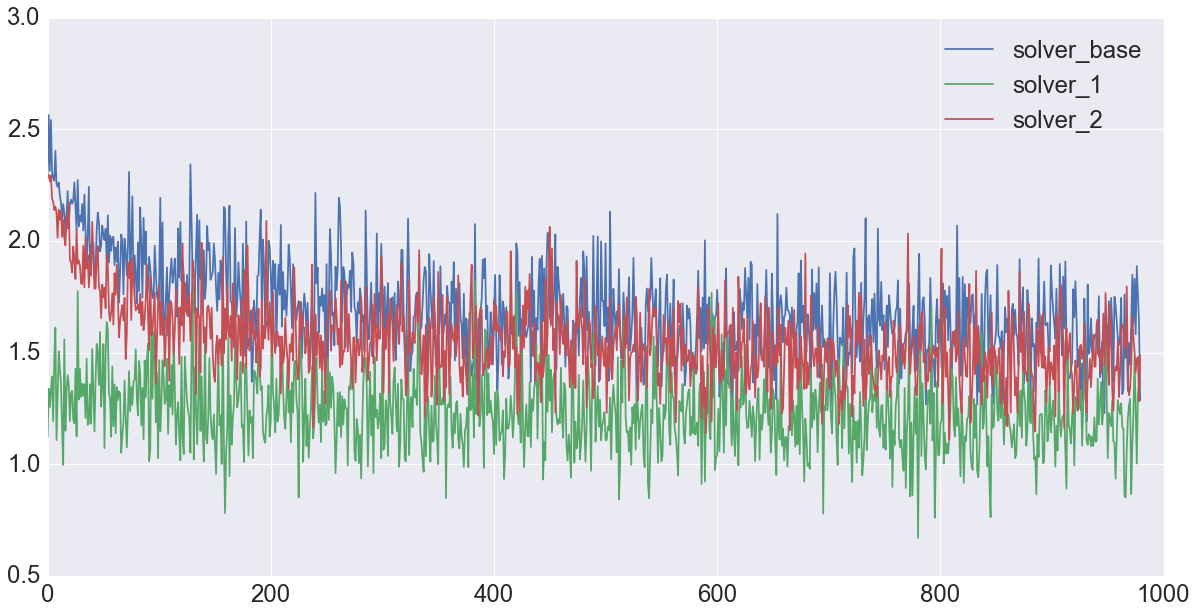

In [202]:
import seaborn as sns
def plot_loss(solvers):
    fig = plt.figure(figsize = (20,10))
    ax = plt.subplot(111)
    for key,solver in solvers.iteritems():
        ax.plot(solver.loss_history, label =key)
        
    ax.legend(fontsize = 24)
    ax.tick_params(labelsize = 24)
        
solvers = {'solver_base':solver_base,
          'solver_1': solver_1,
          'solver_2': solver_2}
plot_loss(solvers)

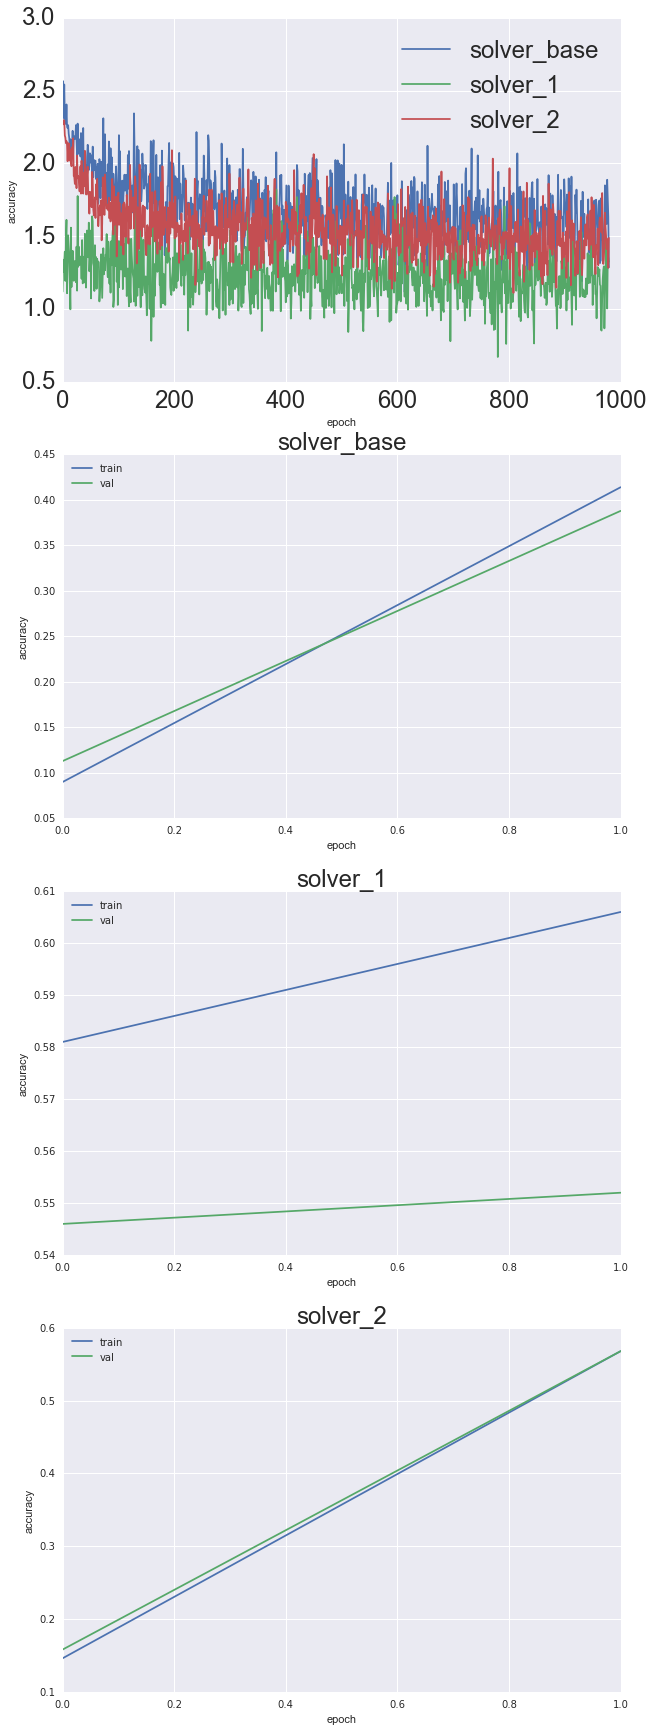

In [203]:
inspect_solvers(solvers)

# Extra Credit Description
If you implement any additional features for extra credit, clearly describe them here with pointers to any code in this or other files if applicable.

In [53]:
import json
class ModelExp(object):
    ''' Class to handle the different model run for the experiments '''
    def __init__(self,model):
        self.model = model
        self.versions = [f for f in os.listdir(model) if f[:2] == 'lr']
        
    def __str__(self):
        conf_file = os.path.join(self.model,'conf_init.json')
        with open(conf_file, 'r') as f:
            conf = json.load(f)
        for key,elt in conf.iteritems():
                print str(key),' : ', str(elt)
        
    def get_best_val(self):
        d = self.get_checkpoints()
        return {key:f['best_val_acc'] for key,f in d.iteritems()}
    
    def get_best_model(self):
        d = self.get_checkpoints()
        return {key:[f['best_val_acc'],f['best_params'],f['model']] for key,f in d.iteritems()}
    
    
    def get_checkpoint_name(self,version):
        ''' Given a specific version of the model ,return the name of the last checkpoint '''
        
        path = os.path.join(self.model,version,'checkpoints')
        return 'check_'+str(max(map(int,[f.split('_')[-1] for f in os.listdir(path)])))

    def get_checkpoints_name(self):
        ''' Return a dict with the different version and their corresponding last checkpoints name '''
        
        return {key:self.get_checkpoint_name(os.path.join(self.model,key)) for key in self.versions}

    def get_checkpoint(self,version,name):
        ''' Given a version of the model and a checkpoint name, return the checkpoit itself'''
        
        return joblib.load(os.path.join(self.model,version,'checkpoints',name,name+'.pkl'))
    
    def get_last_checkpoint(self,version):
        ''' Given a version of the model, return the last checkpoint itselfk'''
        name = self.get_checkpoint_name(version)
        return joblib.load(os.path.join(self.model,version,'checkpoints',name,name+'.pkl'))        
        
    def get_checkpoints(self):
        ''' Return a dict with the different version and their corresponding last checkpoints '''
        
        d = self.get_checkpoints_name()
        return {version:self.get_checkpoint(version,name) for version,name in d.iteritems()}
    
    def inspect_last_checkpoint(self,version,ymax):
        check = self.get_last_checkpoint(version)
        fig = plt.figure(figsize=(15, 5))
        ax1 = plt.subplot(121)
        ax1.plot(check['loss_history'], label=version)
        ax1.set_xlabel('epoch')
        ax1.set_ylabel('accuracy')
        ax1.set_title(version,fontsize = 24)
        ax1.legend(loc = 'upper right',fontsize = 24)
        ax1.set_ylim(0,ymax)
        ax2 = plt.subplot(122)
        ax2.plot(check['train_acc_history'],label = version+'-train')
        ax2.plot(check['val_acc_history'],label = version+'-val')
        ax2.set_xlabel('epoch')
        ax2.set_ylabel('accuracy')
        ax2.legend(loc = 'lower right',fontsize = 24)
        ax2.set_title(version,fontsize = 24)       
        
    def inspect_checkpoints(self):
        ''' solvers is a dict with key:solver.
        Return a plot with the different loss on of top of another '''
        checks = self.get_checkpoints()
        
        fig = plt.figure(figsize=(10, 10))
        height = len(checks) + 1
        ax = plt.subplot(height, 1, 1)
        axs = [plt.subplot(height, 1, i + 2) for i in range(len(checks))]

        i = 0
        for key, check in checks.iteritems():
            ax.plot(check['loss_history'], label=key)
            ax.legend(fontsize=24)
            ax.tick_params(labelsize=12)
            ax.set_xlabel('epoch')
            ax.set_ylabel('accuracy')
            ax.set_ylim(0,5)
            axs[i].plot(check['train_acc_history'])
            axs[i].plot(check['val_acc_history'])
            axs[i].legend(['train', 'val'], loc='upper left')
            axs[i].set_xlabel('epoch')
            axs[i].set_ylabel('accuracy')
            axs[i].set_title(key, fontsize=24)
            i += 1    

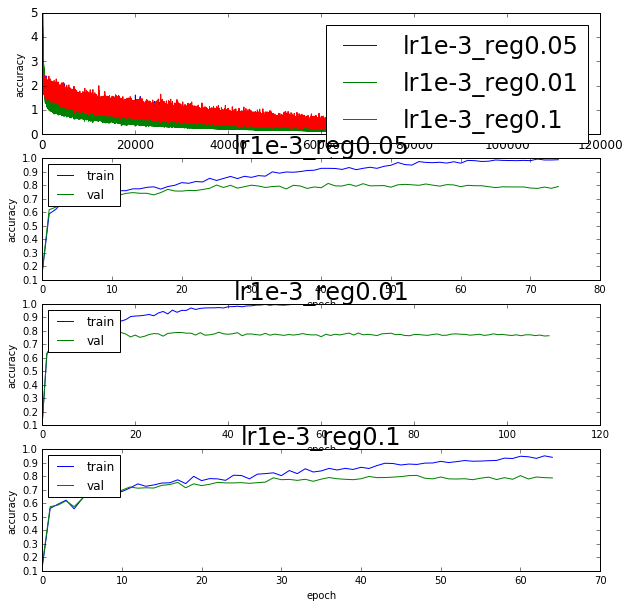

In [54]:
roots = '/Users/thorey/Documents/MLearning/CS231/assignment2'
model_0 = ModelExp(os.path.join(roots,'experiments','FirstConvNet','model_0'))
model_0.inspect_checkpoints()

In [23]:
model_0.__str__()

use_batchnorm  :  True
verbose  :  False
check_points_every  :  1
num_filters  :  [16, 32, 64, 128]
batch_size  :  50
update_rule  :  adam
filter_size  :  3
print_every  :  10
hidden_dim  :  [256, 256]
input_dim  :  [3, 32, 32]
num_epochs  :  2000
path  :  /Users/clement/Documents/MLearning/CS231/assignment2/experiments/FirstConvNet/model_0
weight_scale  :  0.05
lr_decay  :  0.95
num_classes  :  10


In [24]:
model_0.get_best_val()

{'lr1e-3_reg0.01': 0.79000000000000004,
 'lr1e-3_reg0.05': 0.81399999999999995,
 'lr1e-3_reg0.1': 0.80800000000000005}

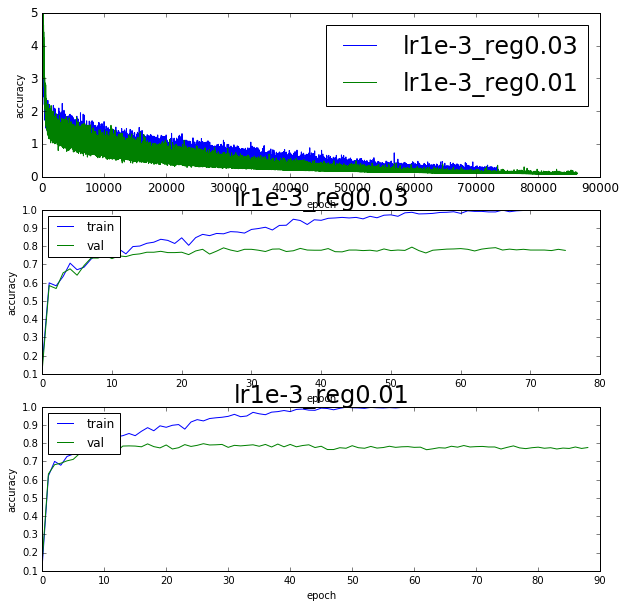

In [67]:
model_1 = ModelExp(os.path.join(roots,'experiments','FirstConvNet','model_1'))
model_1.inspect_checkpoints()

In [26]:
model_1.__str__()

use_batchnorm  :  True
verbose  :  False
check_points_every  :  1
num_filters  :  [16, 32, 64, 128]
batch_size  :  50
update_rule  :  adam
filter_size  :  3
print_every  :  10
hidden_dim  :  [500, 500]
input_dim  :  [3, 32, 32]
num_epochs  :  2000
path  :  /Users/clement/Documents/MLearning/CS231/assignment2/experiments/FirstConvNet/model_1
weight_scale  :  0.05
lr_decay  :  0.95
num_classes  :  10


In [27]:
model_1.get_best_val()

{'lr1e-3_reg0.01': 0.79700000000000004, 'lr1e-3_reg0.03': 0.79500000000000004}

Do a little worse, may be too much capactity. all CNN are overfitting !

# Best model 

In [55]:
best_model = model_0.get_best_model()

In [62]:
bestmodel = best_model['lr1e-3_reg0.05'][2]
bestmodel.params = best_model['lr1e-3_reg0.05'][1]

In [65]:
check_accuracy(bestmodel,data['X_val'],data['y_val'])

0.81399999999999995

In [66]:
check_accuracy(bestmodel,data['X_test'],data['y_test'])

0.78800000000000003

## Ensemble 

In [80]:
def get_ensemble():
    ensemble_model_0 = {'model_0_'+key:val for key,val in model_0.get_best_model().iteritems()} 
    ensemble_model_1 = {'model_1_'+key:val for key,val in model_1.get_best_model().iteritems()} 
    ensemble_model_0.update(ensemble_model_1)
    list_model = []
    for key,elt in ensemble_model_0.iteritems():
        model = elt[2]
        model.params = elt[1]
        list_model.append(model)
    return list_model

In [81]:
ensembles = get_ensemble()

In [96]:
def compute_score_ensemble(ensemble,X,y,num_samples = None,batch_size = 100):
        N = X.shape[0]
        if num_samples is not None and N > num_samples:
            mask = np.random.choice(N, num_samples)
            N = num_samples
            X = X[mask]
            y = y[mask]

        # Compute predictions in batches
        num_batches = N / batch_size
        if N % batch_size != 0:
            num_batches += 1
        y_pred = []
        for i in xrange(num_batches):
            start = i * batch_size
            end = (i + 1) * batch_size
            scores = np.zeros((end-start,10))
            for model in ensemble:
                scores += model.loss(X[start:end])
            scores /= float(len(ensemble))
            y_pred.append(np.argmax(scores, axis=1))
        y_pred = np.hstack(y_pred)
        acc = np.mean(y_pred == y)
        
        return acc

In [97]:
compute_score_ensemble(ensembles,data['X_val'],data['y_val'])

0.85599999999999998

In [98]:
compute_score_ensemble(ensembles,data['X_test'],data['y_test'])

0.86799999999999999

Not too bad !!